* Loads output of tidy diagnoses
* Filter that for desired target and time horizons.
    * Possible filterings for less leakage: Keep diagnoses from before gallbladder and/or all from+during first ukbb intake visit (fixed date?).
        * This is still leaky but a bit less so?
    * Could also do model on followup subcohort - future disease - prediction. (But then we will only have ~50k subjects!!) 
* Then join that with mroe features
* Then do modelling and get interesting features

-----------------
UKBB first cohort dates: ~ 2006-2010 - 

 First repeat assessment visit (2012-13).
 
 https://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=53
 


TODO: Filter diags/features (and as target) in future predictions -
* e.g. 4 years before future diagnoss date or use ukbb date, whichever is later;
* or +- sample by age of disease onset (And impute for negatives)



* Could use Algorithmicallydefined outcomes
(ADOs) for targets (but not alldiseases covered) - those also focus on past/first occurrence I think? 
https://biobank.ndph.ox.ac.uk/showcase/showcase/docs/alg_outcome_main.pdf

* Diagnoses/healthcare primary data - covers about 270K people up to 2017.


* Q on ICD10 diagnoses: **Is it only first occurrence of code recorded**? if so then we need to **remove cases with disease history!**

--------------------
* Another relevant work:
    * "Maternal smoking during pregnancy is risk factor for gallbladder disease in offspring during adulthood: a prospective study from UK Biobank"

    https://doi.org/10.1016/j.aohep.2021.100558

Existing UKBB work:
* "Unravelling environmental and genetic drivers of gallstone disease" (Lacks link to published paper?)
    *  https://www.ukbiobank.ac.uk/enable-your-research/approved-research/unravelling-environmental-and-genetic-drivers-of-gallstone-disease

* Also used UKBB + FinGen (detection): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10159218/
    * "Exploration of the Causal Association Between Behavioral Risk Factors and Gallstone Disease Development in Two European Ancestry Populations"
```
Using publicly available genome-wide association studies (GWAS) data, we performed a two-sample Mendelian randomization (MR) to examine the association between risk factors and gallstone development. Exposures used in this study included age of smoking initiation, smoking intensity, coffee intake, cheese intake, salad intake, processed meat intake, BMI, and lipid biomarkers (cholesterol, low-density lipoproteins (LDL), triglycerides (TG), and high-density lipoproteins (HDL)). Current analyses were based on 93 single nucleotide polymorphisms (SNPs) for smoking initiation, four SNPs for smoking intensity, 65 SNPs for cheese intake, three SNPs for coffee intake, 22 SNPs for salad intake, 23 SNPs for processed meat intake, 79 SNPs for BMI, 26 SNPs for maternal DM, 89 SNPs for total bilirubin, 46 SNPs for cholesterol, 41 SNPs for LDL, 55 SNPs for TG, and 89 SNPs for HDL. The outcome in this study is gallstones/cholelithiasis.
```
      

In [1]:
# !pip install arfs feature_engine
# !conda install pyarrow -y
# !conda install fastparquet -y
# !conda update --all -y
# !conda install sentence-transformers -y
# !conda update --all -y
# !pip uninstall pyarrow -y

In [2]:
import pandas as pd
import numpy as np

# import polars as pl
# https://www.kaggle.com/code/behroozsohrabi/pandas-vs-polars-a-bear-fight#Pivoting

from sklearn.feature_selection import f_classif,SelectFpr, chi2,SelectFdr,VarianceThreshold,mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, SelectPercentile
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
# imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict
# https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#id1
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.ensemble import HistGradientBoostingClassifier , RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from feature_engine.imputation import RandomSampleImputer

from arfs.preprocessing import OrdinalEncoderPandas
from sklearn.feature_selection import mutual_info_classif
from pandas.api.types import is_datetime64_ns_dtype
import sklearn
%load_ext autoreload
%autoreload 2
from util import *

# print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [3]:
# # DIAG_TIDY_PATH = "ukbb-hack/df_diag_tidy.parquet"
# DIAG_TIDY_PATH = "../../ukbb-hack/df_diag_tidy.parquet"
# DIAG_TIDY_PATH =  "../../ukbb-hack/df_diag_tidy.parquet"
# EHR_FEAT_TIDY_PATH = "../../df_ukbb_aux_tidy.parquet"
DIAG_TIDY_PATH =  "../ukbb-hack/df_diag_tidy.parquet"
EHR_FEAT_TIDY_PATH = "../df_ukbb_aux_tidy.parquet"

phenocodes_map_file_path="Phecode_map_v1_2_icd10_beta.csv.zip" #"../../Phecode_map_v1_2_icd10_beta.csv.zip"#"../../Phecode_map_v1_2_icd10_beta.csv.zip"
# phenocodes_def_file_path="../../phecode_definitions1.2.csv.zip"#"phecode_definitions1.2.csv.zip"
phenocodes_def_file_path="phecode_definitions1.2.csv.zip"#"

In [4]:
# ## check type 1 diabetes
# TARGET_CODES_LIST = ("E109")

In [5]:
## Cholelithiasis = gallstones
TARGET_CODES_LIST = ("K80")# ,"K81","K÷82") #("K80","K56.3") # doesn't include other obstructionso r gallbladder diseases
# TARGET_CODES_LIST =("C15") # Oesophagus cancer. C15.9 = unspecifiedNote - may be in cause of death, not historical diagnoses.. - 1275 . Compare to: "Development and validation of a novel risk prediction algorithm to estimate 10-year risk of oesophageal cancer in primary care: prospective cohort study and evaluation of performance against two other risk prediction models"
# TARGET_CODES_LIST = ("M10","M1A") # Gout
# TARGET_CODES_LIST = ("K90") # Celiac/Coeliac disease
# TARGET_CODES_LIST = ("G35") # MS - multiple sclerosis.
## M40-M54 : Dorsopathy = diseases of the spine and paravertebral tissues (inc back pain!).
### https://www.aapc.com/codes/icd-10-codes/M51   # ,"M54.5" = lower back pain
# TARGET_CODES_LIST = ("M51.3","M51.2","M51.0","M51.1","M51.3","M47") #intervertebral disc degeneration(Lumbar is M51.36). M51.2 = disc displacement. M47 = Spondylosis
## heart - lots of subcats (chronic, angina, nonischemic (ischemia = blood flow), MI, IHF....; Myocardial infarction (MI) = "heart attack,"
## lacks cases of death due to that...
# TARGET_CODES_LIST = ("I21.9") ## Heart attack
## Central retinal artery occlusion (Central retinal artery occlusion: H34.1) is a type of stroke that must be treated immediately. 
# TARGET_CODES_LIST = ("H34")#("H34.1") ## Retinal Vein Occlusion . (Central retinal artery occlusion: H34.1 = rare). Others - H34

## future ids filter seems to result in losing past dcases? don't know why, don't use for now!
FILTER_HAS_ANY_FUTURE_DIAGS = True#True ## filter to keep cases with any future/post 2010 diagnoses = future record acquisition. May be leaky or unneeded
FILTER_HAS_ANY_DIAG_IDS =  False #True
ROUND_PHEWAS_CODE_PREC = False# True ## round phentypes code prec to 1 digit
JOIN_CHOL_FEATS = True
FUTURE_DIAG_CUTOFF_YEARS = 1#1 # in application we look at - of this val
FILTER_TARGET_FUTURE_HORIZON = False#True ## filter for cases within ~3 years (2014) of ukbb - closer horizon, but less cases! 

## If doing MS:
USE_TARGET_FROM_ANYTIME = False   ### Include past cases for target, as well as future. Super leaky! use for e.g. MS 

FILTER_FEMALES_ONLY = False#True ## Keep only females in data. For Gallstones - ROCauc is stable on this subset, as are few top features seemingly.
PIVOT_DIAGS_COL_NAME = "phenotype" #"code" #"phenotype" 
K_diag_thresh_value = 250#800#250#500
FAST_SAMPLE_SIZE= 40_000 #60_000
CORR_THRESH = 0.9#0.95
do_stat_fs_filt = True#False#True # Leaky feature selection - can be slow
do_boruta_fs = False #True # do leaky borutaShap/arfs all relevant FS in advance. Slow, leaky
do_mi_fs_filt = True ## filter by avbs mi vaue

# ## get diag feats by z-score, most extreme, or time since most recent value. Recentmost i much faster to extract
# GET_EXTREMETMOST_DIAGFEATS =  True#False#True
# GET_RECENTMOST_DIAGFEATS = False# True # False
GET_EXTREMETMOST_DIAGFEATS =  False
GET_RECENTMOST_DIAGFEATS = True

FAST = True  #False
# SAVE_OUTPUT =True
SAVE_OUTPUT =False


# if FAST:SAVE_OUTPUT = False

OUTPUT_FEATURE_REPORT_NAME = "gallbladder_ipw_feature_report.csv"
# OUTPUT_FEATURE_REPORT_NAME = "ukb_gallstone_feature_report.csv"
# OUTPUT_FEATURE_REPORT_NAME = "female_gallstone_feature_report.csv"

# OUTPUT_FEATURE_REPORT_NAME = "heart_feature_report.csv"
# OUTPUT_FEATURE_REPORT_NAME = "gout_ipw_feature_report.csv"
# OUTPUT_FEATURE_REPORT_NAME = "celiac_feature_report.csv"
# OUTPUT_FEATURE_REPORT_NAME = "MS_ipw_feature_report.csv"#"MS_feature_report.csv"#"MS_ipw_feature_report.csv"
# OUTPUT_FEATURE_REPORT_NAME = "spine_degen_feature_report.csv"
# OUTPUT_FEATURE_REPORT_NAME = "oesophagus_feature_report.csv"
# OUTPUT_FEATURE_REPORT_NAME = "eye_occ_ipw_feature_report.csv"

DO_CV = False

DO_IPW_SAMPLING =  True
K_IPW_RATIO =  2#19#4#9#11#1

REMOVE_CASES_WITH_PAST_TARGET = False#True ## Remove from dataset entirely cases/patients who had one of our targets diagnosed in the past.

In [6]:
assert GET_EXTREMETMOST_DIAGFEATS != GET_RECENTMOST_DIAGFEATS

In [53]:
ipw_propensity_cols_list = ['age',
                            'Sex',
                            'age_X_sex',
                            "(BMI) Body mass index (p21001)",
                                # 'Body mass index (BMI)(participant - p21001)',
                            # "Weight(participant - p21002_i0)",
                            # "had_disease_past" # past disease history - not sure if we want to use
                           ]  ## use in IPW propensity calcing

list_cols_replace_isna_feat = ["Fitness test results, including ECG data",
                               "Acceptability of each blow result (text) | Array 0"]
list_sequential_features = ['Light - Day average',
       'Sedentary - Day average', 'Sleep - Day average',
       'Sleep - Weekday hour average', 'Sleep - Weekend hour average',
 'Pulse wave pressure versus time response curve'] # some features that are sequences of numbers - need more processing to use

actually_numeric_cat_cols_list = ['Coffee intake', 'Tea intake', 'Water intake',
'Age when diabetes-related eye disease diagnosed', 'Age diabetes diagnosed','Age heart attack diagnosed']

DROP_FEAT_COLS_LIST = ["cutoff_date","prediction_cutoff_year",
                      'PRS genetic principal components | Array 0',
                      'PRS genetic principal components | Array 1',
                      'PRS genetic principal components | Array 2',
                      'PRS genetic principal components | Array 3',
                      'PRS genetic principal components | Array 4',] # prediction_cutoff_year - important, maybe leaky feat?

# ### If doing MS / anytime
# ## drop otherwise!!!
# ## MS leakage related:
# DROP_FEAT_COLS_LIST.extend([
# "Other serious medical condition/disability diagnosed by doctor_Yes - you will be asked about this later by an interviewer",
# "Non-cancer illness code, self-reported | Array 0__multiple sclerosis",
# "Non-cancer illness code, self-reported | Array 1__multiple sclerosis",
# "Non-cancer illness code, self-reported | Array 2__multiple sclerosis",
# "Other serious medical condition/disability diagnosed by doctor_No",
# "Long-standing illness, disability or infirmity_Yes",
# "Long-standing illness, disability or infirmity_No",
# "missing_Symptoms involving nervous and musculoskeletal systems",
# "Symptoms involving nervous and musculoskeletal systems",
# "Other serious medical condition/disability diagnosed by doctor",
# "Non-cancer illness code, self-reported",
# "Long-standing illness, disability or infirmity",
# "Non-cancer illness code, self-reported | Array 0",
# "Non-cancer illness code, self-reported | Array 1",
# "Non-cancer illness code, self-reported | Array 2",
# "Number of self-reported non-cancer illnesses"])

# ## toadd - the new datetime, datetime na cols. 

In [8]:
def get_most_extreme(df,value_col="Z-score-Age_at_diagnosis"):
    idx = df[value_col].abs().idxmax()
    return df.loc[idx]
def get_min_time_vals(df,time_col="Diagnosis Date",val_cols=[ 'Z-score-Age_at_diagnosis']):
    # Group by 'eid' and get the index of the row with the latest date for each group
    idx = df.groupby('eid')[time_col].idxmin()
    # Use the index to filter the rows with the latest date
    return df.loc[idx, ['eid'] + val_cols].set_index('eid')

def get_max_time_vals(df,time_col="Diagnosis Date",val_cols=['Z-score-Age_at_diagnosis']):  
    # Group by 'eid' and get the index of the row with the latest date for each group
    idx = df.groupby('eid')[time_col].idxmax()
    # Use the index to filter the rows with the latest date
    return df.loc[idx, ['eid'] + val_cols].set_index('eid')

def filter_min_code_counts(df,K_value=200,codeColName="code"):
    # Count occurrences and filter codes as before
    code_counts_refined = df[codeColName].value_counts()
    print(len(code_counts_refined),"# all code_counts")
    codes_to_keep_refined = code_counts_refined[code_counts_refined >= K_value].index
    print(len(codes_to_keep_refined),"# codes_to_keep_refined")
    
    df = df.loc[df[codeColName].isin(codes_to_keep_refined)].reset_index(drop=True)
    if df[codeColName].dtype == "category":
        df[codeColName] = df[codeColName].cat.remove_unused_categories()
    return df
    
def pivot_long_col_diags(df,K_value=5_00,value_col="Z-score-Age_at_diagnosis",codeColName="code",
                         get_most_extreme_val = True,
                         get_max_val = False, # may be best to do seperately
                         subtractionCol = "age", 
                         # try_polars = False
                        ):
    assert get_most_extreme_val != get_max_val,f"get_most_extreme_val({get_most_extreme_val}) must differ from get_max_val{get_max_val}"
    df = df.dropna(subset=[codeColName,value_col],axis=0)#.drop_duplicates() # added
    df = filter_min_code_counts(df=df,K_value=K_value,codeColName=codeColName)#.reset_index(drop=True)

    if get_most_extreme_val:
        df = df.groupby(['eid', codeColName],observed=True)
        # Define a function to get the row with the most extreme Z-score for each eid-code pair
        # Apply the function and reset index
        df = df.apply(get_most_extreme,value_col=value_col).reset_index(drop=True)

    elif get_max_val: # not tested
        df = df.sort_values(by=["eid",value_col,codeColName],ascending = False).drop_duplicates(["eid",value_col,codeColName])
        df[value_col] = df[value_col].sub(df[subtractionCol])
    df = df.pivot_table(
    values=value_col,
    index="eid",
    columns=codeColName,
    observed=True
)
        
    df = df.reset_index().set_index("eid")
    return df

from sklearn.base import BaseEstimator, TransformerMixin
# Custom transformer to convert boolean to string
class BooleanToStringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.astype(str)
        
def downcast_number_dtypes(df):
    ## downcast datatypes 
    for col in df.select_dtypes('number'):
        df[col] = pd.to_numeric(df[col], downcast='integer')
        if df[col].dtype == 'float':
            df[col] = pd.to_numeric(df[col], downcast='float')
    print(df.dtypes)
    return df


def split_pipe_delimited_columns(df, columns, prefix=True):
    for col in columns:
        df[col] = df[col].str.replace("None of the above","None")
        split_cols = df[col].str.split('|', expand=True)
        if prefix:
            split_cols = split_cols.add_prefix(f'{col}_')
        df = df.drop(columns=[col]).join(split_cols)
    return df

def cv_eval(X,y,n_cv=4,model=None):
    score_metrics = ["roc_auc",'accuracy', 'precision',"recall","average_precision","f1"] # ,"balanced_accuracy"
    if model is None:
        model = CatBoostClassifier(iterations=500,
                                   auto_class_weights="SqrtBalanced" # SqrtBalanced "Balanced"
                           ,early_stopping_rounds=50
                           # task_type="GPU",
                           ,verbose=False,
                            # cat_features=(categorical_cols+text_cols), ),
                           cat_features=X.select_dtypes(["O","string","category","object"]).columns.to_list(),)
    native_result = cross_validate(
        # pipeline,
        model,
        X,y,cv=n_cv
       # ,cv=3 if FAST else 4
       ,scoring=score_metrics) # ,n_jobs=3,
    
    for metric in score_metrics:
        metric_mean = np.mean(native_result[f"test_{metric}"])
        metric_std = np.std(native_result[f"test_{metric}"])
        print(f"{metric}: {100*metric_mean:.2f} +-{metric_std:.3f} SD")


## "Body mass index (BMI)(participant - p23104_i0)"
def IPW_resample(df,propensity_cols_list=['Sex','age', 'age_X_sex',  "Body mass index (BMI)(participant - p23104_i0)"],
                 K_IPW_RATIO = 4,X=None,get_ipw_shap = False):
    # K_IPW_RATIO = 1 if FAST else 3 #3
    
    X_ipw = OrdinalEncoderPandas().fit_transform(df[propensity_cols_list])
    X_ipw["eid"] = df["eid"]
    clf_cal = CalibratedClassifierCV(
        estimator=HistGradientBoostingClassifier(max_iter=500,categorical_features="from_dtype" # ["Sex"] #
                                                 ,random_state=42,),
        # estimator=LogisticRegression(),
            method="isotonic"
    )
    
    dmg_propensity = cross_val_predict(estimator=clf_cal,
        X=X_ipw.drop(columns=["eid"],errors="ignore"),n_jobs=-1,cv=5,
        y=df["y"],method='predict_proba',)[:,1]
    df_ipw = df.copy()
    df_ipw["propensity"] = dmg_propensity#[:,1]
    
    # positive_class_propensity_cutoff = df_ipw.loc[df_ipw["y"]>0]["propensity"].quantile(0.001)
    # print(positive_class_propensity_cutoff)
    # # df_ipw_subset = df_ipw.loc[(df_ipw["propensity"]>=positive_class_propensity_cutoff)|(df_ipw["y"]>0)]
    df_ipw_subset = df_ipw.loc[(df_ipw["propensity"]>0)|(df_ipw["y"]>0)]
    print(df_ipw_subset.shape[0])
    # df_ipw_subset.groupby(["y"])["propensity"].plot(kind="kde")
    
    ## IPW weighted sampling! 
    df_pos = df_ipw_subset.loc[df_ipw_subset["y"]>0]
    num_pos = df_ipw_subset["y"].sum()
    df_neg = df_ipw_subset.loc[df_ipw_subset["y"]==0]
    df_neg = df_neg.sample(n= min((K_IPW_RATIO*num_pos),df_neg.shape[0]),weights="propensity")
    
    df_ipw_subset = pd.concat([df_pos,df_neg]).drop(columns=["propensity"]).drop_duplicates()
    print("After IPW downsampling:",df_ipw_subset.shape[0])
    # df_ipw_subset.groupby(["y"])["propensity"].plot(kind="kde")
    
    df_subset_ipw = df.loc[df["eid"].isin(df_ipw_subset["eid"])].dropna(axis=1,thresh=50).copy()
    
    if get_ipw_shap:
        print("Getting IPW based SHAP")
        X_subset_ipw = df_subset_ipw.filter(X.columns.tolist(),axis=1).dropna(axis=1,thresh=100)
        
        categorical_cols,text_cols,numerical_cols = get_coltypes_list(X_subset_ipw)
        
        _ =get_cb_shap(X=X_subset_ipw,
                       y=df_subset_ipw["y"],
                       categorical_cols=categorical_cols,text_cols=text_cols)
    return df_ipw_subset

# IPW_resample(df,propensity_cols_list=['Sex','age', 'age_X_sex', "Body mass index (BMI)(participant - p23104_i0)"],
#                  K_IPW_RATIO =1,X=X,get_ipw_shap = True)

def get_coltypes_list(X:pd.DataFrame,return_X = False):
    text_cols_list = X.select_dtypes(["O","string","category"]).columns.tolist()
    
    # X.filter(text_cols_list,axis=1).loc[X.filter(text_cols_list,axis=1).nunique()>15]
    m = X.filter(text_cols_list,axis=1).nunique()> 80#20
    list_features_high_cardinality = list(X.filter(text_cols_list,axis=1).nunique()[m].index)
    # print(list_features_high_cardinality)
    categorical_cols = X[text_cols_list].columns.difference(list_features_high_cardinality).to_list()

    # Define categorical, numerical and text columns
    # categorical_cols = categorical_cols  # Update with your actual categorical columns
    text_cols =  list_features_high_cardinality # Update with your actual text columns
    numerical_cols = X.select_dtypes(include=['number',"boolean"]).columns.difference(categorical_cols + text_cols).to_list()
    print("text_cols",text_cols)
    
    if return_X: 
        for c in text_cols:
            X[c] = X[c].fillna("None").astype(str)#.astype("O")#.astype("category") #.astype(str)
        X[categorical_cols] = X[categorical_cols].astype(str).fillna("Empty").astype("category") # handle mixed Object/Booleans
        # X[categorical_cols] = X[categorical_cols].astype(str).astype("category") # try without imputing
        return X, categorical_cols,text_cols,numerical_cols
    else:
        return categorical_cols,text_cols,numerical_cols

def get_cb_shap(X,y,categorical_cols,text_cols,return_shapVal = True):
    # X2 = X.head(X.shape[0]//30).copy().reset_index(drop=True)
    X2 = X
    
    clf_model2 = CatBoostClassifier(#depth=5,iterations=800, 
        auto_class_weights="SqrtBalanced" #"SqrtBalanced" # SqrtBalanced "Balanced"
                               ,early_stopping_rounds=90
                               # task_type="GPU",
                               # cat_features=X2.select_dtypes(["O","string","category","object"]).columns.to_list(),
                               ,verbose=False,
        eval_fraction=0.05,
        cat_features=(categorical_cols+text_cols),
        #text_cols - seemingly broken in current catboost?  
        # cat_features=categorical_cols,#+text_cols,
        # text_features=["Treatment/medication code | Array 0"] #text_cols ## seemingly broken? 
        # text_features=text_cols 
                                )
    
    clf_model2.fit(X2,y.head(X2.shape[0]),plot=False)
    explainer = shap.Explainer(clf_model2)
    
    print("fitted")
    
    shap_values = explainer(X2, y=y.head(X2.shape[0]))
    
    shap.plots.beeswarm(shap_values,max_display=30) # ,log_scale=True
    if return_shapVal:
        shap_values = np.abs(shap_values.values).mean(0)# get abs val
        return shap_values

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.validation import check_X_y, check_array
from sklearn.utils import check_random_state
from joblib import Parallel, delayed
import warnings

def conditional_mutual_info(X, y, z, n_neighbors=3, random_state=None):
    """
    Estimate the conditional mutual information I(X; y | z) using the KSG estimator.

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        Feature variable.
    y : array-like, shape (n_samples,)
        Target variable.
    z : array-like, shape (n_samples, n_features)
        Conditioning variables.
    n_neighbors : int, default=3
        Number of nearest neighbors to use.
    random_state : int or RandomState instance, default=None
        Random number generator seed control.

    Returns
    -------
    cmi : float
        Estimated conditional mutual information.
    """
    # Ensure inputs are numpy arrays
    X = np.asarray(X).reshape(-1, 1)
    y = np.asarray(y).reshape(-1, 1)
    z = np.asarray(z)

    # Concatenate variables
    xyz = np.hstack((X, y, z))
    xz = np.hstack((X, z))
    yz = np.hstack((y, z))
    z = np.asarray(z)

    # Number of samples
    n_samples = X.shape[0]

    # Set up nearest neighbors
    nn_xyz = NearestNeighbors(n_neighbors=n_neighbors + 1)
    nn_xz = NearestNeighbors(n_neighbors=n_neighbors + 1)
    nn_yz = NearestNeighbors(n_neighbors=n_neighbors + 1)
    nn_z = NearestNeighbors(n_neighbors=n_neighbors + 1)

    # Fit the models
    nn_xyz.fit(xyz)
    nn_xz.fit(xz)
    nn_yz.fit(yz)
    nn_z.fit(z)

    # Distances
    dists_xyz, _ = nn_xyz.kneighbors(xyz, n_neighbors=n_neighbors + 1)
    dists_xz, _ = nn_xz.kneighbors(xz, n_neighbors=n_neighbors + 1)
    dists_yz, _ = nn_yz.kneighbors(yz, n_neighbors=n_neighbors + 1)
    dists_z, _ = nn_z.kneighbors(z, n_neighbors=n_neighbors + 1)

    # Exclude the point itself (distance zero)
    eps = np.finfo(float).eps
    dists_xyz = dists_xyz[:, n_neighbors] - eps
    dists_xz = dists_xz[:, n_neighbors] - eps
    dists_yz = dists_yz[:, n_neighbors] - eps
    dists_z = dists_z[:, n_neighbors] - eps

    # Counts
    nxz = np.sum(nn_xz.radius_neighbors_graph(xz, radius=dists_xyz, mode='connectivity'), axis=1) - 1
    nyz = np.sum(nn_yz.radius_neighbors_graph(yz, radius=dists_xyz, mode='connectivity'), axis=1) - 1
    nz = np.sum(nn_z.radius_neighbors_graph(z, radius=dists_xyz, mode='connectivity'), axis=1) - 1

    # Avoid log of zero
    nxz = np.maximum(nxz, 1)
    nyz = np.maximum(nyz, 1)
    nz = np.maximum(nz, 1)

    # Compute conditional mutual information
    psi = lambda x: np.log(x)
    cmi = np.mean(psi(nxz) + psi(nyz) - psi(n_neighbors) - psi(nz))

    return cmi
class CMIMFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Conditional Mutual Information Maximization (cmim) feature selector.
    """

    def __init__(self, n_features_to_select=None, task='classification', n_neighbors=3, n_jobs=-1, random_state=None):
        self.n_features_to_select = n_features_to_select
        self.task = task
        self.n_neighbors = n_neighbors
        self.n_jobs = n_jobs
        self.random_state = random_state

    def fit(self, X, y):
        # Validate inputs
        X, y = check_X_y(X, y, accept_sparse=False)
        self.n_samples_, self.n_features_ = X.shape

        if self.n_features_to_select is None:
            self.n_features_to_select = self.n_features_

        if self.n_features_to_select > self.n_features_:
            raise ValueError("Cannot select more features than available")

        self.selected_features_ = []
        self.feature_scores_ = np.zeros(self.n_features_)  # Stores CMI scores for all features
        self.mi_scores_ = np.zeros(self.n_features_)       # Stores initial MI scores for all features
        self.m_ = -np.ones(self.n_features_, dtype=int)
        self.t1_ = np.zeros(self.n_features_)

        # Initialize mutual information between each feature and the target
        if self.task == 'classification':
            mi = mutual_info_classif(X, y, n_neighbors=self.n_neighbors, random_state=self.random_state)
        elif self.task == 'regression':
            mi = mutual_info_regression(X, y, n_neighbors=self.n_neighbors, random_state=self.random_state)
        else:
            raise ValueError("Task must be 'classification' or 'regression'")

        self.t1_ = mi.copy()
        self.mi_scores_ = mi.copy()

        # Cache for conditional mutual information
        self.cmi_cache_ = {}

        # Main cmim algorithm
        for k in range(self.n_features_to_select):
            # Select the feature with the highest t1
            idx = np.argmax(self.t1_)
            self.selected_features_.append(idx)
            self.feature_scores_[idx] = self.t1_[idx]
            self.t1_[idx] = -np.inf  # Exclude this feature from further selection

            # Update t1 for remaining features
            features_remaining = [i for i in range(self.n_features_) if i not in self.selected_features_]

            for i in features_remaining:
                while self.t1_[i] > self.feature_scores_[idx] and self.m_[i] < len(self.selected_features_) - 1:
                    self.m_[i] += 1
                    j = self.selected_features_[self.m_[i]]

                    # Compute conditional mutual information I(f_i; y | f_j)
                    key = (i, j)
                    if key in self.cmi_cache_:
                        cmi = self.cmi_cache_[key]
                    else:
                        cmi = conditional_mutual_info(
                            X[:, i], y, X[:, j],
                            n_neighbors=self.n_neighbors,
                            random_state=self.random_state
                        )
                        self.cmi_cache_[key] = cmi

                    # Update t1 with the minimal CMI
                    self.t1_[i] = min(self.t1_[i], cmi)

                # Update feature scores for analysis
                self.feature_scores_[i] = self.t1_[i]

        self.selected_features_ = np.array(self.selected_features_)

        # Store the final CMI scores
        self.cmi_scores_ = self.feature_scores_.copy()

        return self

    def transform(self, X):
        # Validate input
        X = check_array(X, accept_sparse=False)
        return X[:, self.selected_features_]

    def get_support(self, indices=False):
        mask = np.zeros(self.n_features_, dtype=bool)
        mask[self.selected_features_] = True
        if indices:
            return self.selected_features_
        else:
            return mask

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = ['x%d' % i for i in range(self.n_features_)]
        return np.array(input_features)[self.selected_features_]


In [9]:
 # pd.read_parquet(DIAG_TIDY_PATH)
 # pd.read_parquet(EHR_FEAT_TIDY_PATH)

In [10]:
#### holds most features, prefenerated from hjoining, includes date of assesment center attendnace etc' . Doesn't hold med codes.
## take date of attending asesment for firstim from here (it's 2009-2011 for most )
## we'll load the full DF later in pipeline. for now, just the metadata we need for filtering!

## "df_ukbb_aux_tidy.parquet" instead of "ukbb-hack/df_diag_tidy.parquet"
df_meta = pd.read_parquet(EHR_FEAT_TIDY_PATH,columns=["Date of attending assessment centre","eid"]).set_index("eid")
df_meta.rename(columns={"Date of attending assessment centre":"instance0_date"},inplace=True)
assert is_datetime64_ns_dtype(df_meta["instance0_date"])
df_meta ## 440K population out of 500K? 

,instance0_date
eid,
1000015,2008-05-02
1000027,2008-01-29
1000039,2009-05-06
1000040,2009-12-10
1000053,2007-12-17
...,...
6026238,2010-06-15
6026246,2009-08-15
6026252,2009-08-24


In [11]:
# DIAG_TIDY_PATH =  "../../ukbb-hack/df_diag_tidy.parquet"
# EHR_FEAT_TIDY_PATH = "../../df_ukbb_aux_tidy.parquet"

df_diag = pd.read_parquet(DIAG_TIDY_PATH)
# df_diag["age"] = df_diag["YOB"].sub(2011).abs().astype(int) # age roughly at time of cutoff # alt - do this after imputing with realt ime
if FILTER_FEMALES_ONLY:
    df_diag = df_diag.query("Sex=='Female'")
    print("Female only")
print(df_diag.shape[0],"# rows pre assesment date filter")
df_diag = df_diag.join(df_meta,how="inner",on="eid") # get instance 0 date . 
assert df_diag.shape[0]>0
df_diag = downcast_number_dtypes(df_diag)
print(df_diag.nunique())
print(df_diag.isna().sum())
assert df_diag.shape[0]>0
assert is_datetime64_ns_dtype(df_diag["instance0_date"])
assert is_datetime64_ns_dtype(df_diag["Diagnosis Date"])
df_diag

6298568 # rows pre assesment date filter
eid                                  int32
YOB                                  int16
Sex                               category
ICD_Code                          category
Diagnosis_Description             category
Diagnosis Date              datetime64[ns]
Age_at_diagnosis                      int8
Z-score-Age_at_diagnosis           float32
instance0_date              datetime64[ns]
dtype: object
eid                         440004
YOB                             37
Sex                              2
ICD_Code                     10151
Diagnosis_Description         8975
Diagnosis Date                9641
Age_at_diagnosis                61
Z-score-Age_at_diagnosis    352166
instance0_date                1068
dtype: int64
eid                            0
YOB                            0
Sex                            0
ICD_Code                       0
Diagnosis_Description          0
Diagnosis Date                 0
Age_at_diagnosis               0

,eid,YOB,Sex,ICD_Code,Diagnosis_Description,Diagnosis Date,Age_at_diagnosis,Z-score-Age_at_diagnosis,instance0_date
0,1000015,1951,Female,K21.9,Gastro-oesophageal reflux disease without oeso...,2013-09-05,62,-0.288096,2008-05-02
0,1000015,1951,Female,K92.2,"Gastro-intestinal haemorrhage, unspecified",2013-11-25,62,-0.273375,2008-05-02
1,1000027,1939,Male,I25.9,"Chronic ischaemic heart disease, unspecified",2012-11-06,73,0.699003,2008-01-29
1,1000027,1939,Male,R07.4,"Chest pain, unspecified",2012-11-06,73,1.375953,2008-01-29
1,1000027,1939,Male,Z92.2,Personal history of long-term (current) use of...,2012-11-06,73,0.657012,2008-01-29
...,...,...,...,...,...,...,...,...,...
440016,6026290,1943,Female,Z88.1,Personal history of allergy to other antibioti...,2014-01-14,71,0.631783,2009-10-22
440016,6026290,1943,Female,Z88.6,Personal history of allergy to analgesic agent,2018-11-30,75,1.071651,2009-10-22
440016,6026290,1943,Female,Z88.8,"Personal history of allergy to other drugs, me...",2014-01-14,71,0.487634,2009-10-22
440016,6026290,1943,Female,Z91.0,"Personal history of allergy, other than to dru...",2018-07-06,75,1.115590,2009-10-22


###  Numcases with *any* future medical diagnoses
* 278,224
* Those without any future diagnoses - could be healthy, or could not be in system? We could drop others - this would change population distribution!

WEIRD: Filtering ids by this seems to drop all   past diagnosis ids, and leave only future ones? Do not understand why/how

In [12]:
## seems to drop all cases with past diagnosis??? 
## I move thisdownstream and (optionally) filter pot. targets according to this , not the raw diags, due to weird issue

# list_ids_any_future_diagnoses = df_diag.loc[df_diag["Diagnosis Date"]>=df_diag["instance0_date"]]["eid"].unique() #ORIG
# new, uses actual intake/instance 0 date:
list_ids_any_future_diagnoses = df_diag.loc[df_diag["Diagnosis Date"]>=df_diag["instance0_date"]]["eid"].unique()
print(len(list_ids_any_future_diagnoses))

387466


#### disease eda
* K80: Cholelithiasis ={Calculus of gallbladder =~ gallbladder stones etc')
    * also "`Gallstone ileus` - a rare form of small bowel obstruction caused by impaction of gallstone within the small intestine." 

* Note neoplasms/cancers , and injury/perforation diagnoses

In [13]:
df_diag.groupby(["eid"])["Diagnosis Date"].nunique().describe()

count    440004.000000
mean          5.872772
std           5.743105
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         117.000000
Name: Diagnosis Date, dtype: float64

In [14]:
print(" intersection of post and past diagnosis codes")
len(set(df_diag.loc[df_diag["Diagnosis Date"]>=df_diag["instance0_date"]]["eid"].unique())\
    .intersection(set(df_diag.loc[df_diag["Diagnosis Date"]<df_diag["instance0_date"]]["eid"].unique())))

 intersection of post and past diagnosis codes


257281

In [15]:
all_codes = df_diag.drop_duplicates(subset=["ICD_Code","Diagnosis_Description","eid"])[["ICD_Code","Diagnosis_Description"]]
print(all_codes.shape[0])
### 225 codes..  Lets take for now Z86.4 , Z72.1, Z72.2 , X6... (self poisoning) , I42.6
# display(all_codes.loc[all_codes["Diagnosis_Description"].str.contains("gall|cholecyst",case=False,na=False)].drop_duplicates())
# all_codes.loc[all_codes["Diagnosis_Description"].str.contains("gall|cholecyst",case=False,na=False)][["ICD_Code","Diagnosis_Description"]].value_counts()

# display(all_codes.loc[all_codes["Diagnosis_Description"].str.contains("gout",case=False,na=False)].drop_duplicates())

6298568


In [16]:
df_diag_target = df_diag.loc[df_diag["ICD_Code"].str.startswith(TARGET_CODES_LIST,na=False)]
print(df_diag_target.shape)
print(df_diag_target["eid"].nunique(),"# patients with disease target at any time of their lives")

(34915, 9)
26307 # patients with disease target at any time of their lives


In [17]:
df_diag_target[["ICD_Code","Diagnosis_Description"]].value_counts()

ICD_Code  Diagnosis_Description                                     
K80.2     Calculus of gallbladder without cholecystitis                 15821
K80.1     Calculus of gallbladder with other cholecystitis               9497
K80.5     Calculus of bile duct without cholangitis or cholecystitis     4633
K80.0     Calculus of gallbladder with acute cholecystitis               3411
K80.4     Calculus of bile duct with cholecystitis                        692
K80.3     Calculus of bile duct with cholangitis                          648
K80.8     Other cholelithiasis                                            213
Name: count, dtype: int64

In [18]:
df_target_future = df_diag_target.loc[df_diag_target["Diagnosis Date"]>=df_diag_target["instance0_date"]].drop_duplicates(["eid","ICD_Code"])
assert df_target_future["Diagnosis Date"].isna().sum() ==0
print(df_target_future["eid"].nunique())
df_target_future.shape[0]

17237


23040

#### Dates of future diagnsis (earliest first) - can use for future cutoff 
* can sample from this also
* Note that it's from 2011 and onwards
* Q: Do we want it to be earliest? many are from UKK date only, and this may reduce performance. (Earlier = tests are more relevant, but may miss more diagnoses..)
    * Could not drop duplicates by eid...?  

In [19]:
df_target_future_dates = df_target_future[["eid","Diagnosis Date"]].sort_values("Diagnosis Date",ascending=True).drop_duplicates(subset=["eid"])

df_target_future_dates = df_target_future_dates.set_index(["eid"]).rename(columns={"Diagnosis Date":"cutoff_date"})
assert df_target_future_dates["cutoff_date"].isna().sum() ==0
# df_target_future_dates

### add features of past history of disease
* skipping specific disease name for now. Getting earlier age
* * Could add feature of "time since most recent diagnoses (current date minus max from before ukbb intake)

In [20]:
df_target_past = df_diag_target.loc[df_diag_target["Diagnosis Date"].dt.year<=2010]
print(df_target_past["eid"].nunique(),"past target IDs")
print(df_target_past.shape[0],"rows")

# df_target_past = df_target_past.groupby("eid")[['Age_at_diagnosis', 'Z-score-Age_at_diagnosis']].min() # 'ICD_Code', 
df_target_past = get_max_time_vals(df_target_past,time_col="Diagnosis Date",val_cols=[ "Age_at_diagnosis",'Z-score-Age_at_diagnosis'])

df_target_past = df_target_past.add_prefix("past disease history - ")
df_target_past["had_disease_past"] = True
### drop duplicates (multiple hisorical disease cases
df_target_past = df_target_past[~df_target_past.index.duplicated(keep='first')]
print(df_target_past.shape[0],"rows")

11612 past target IDs
14678 rows
11612 rows


In [21]:
### our diagnoses records first occurence only per code!
### little to no overlap - (the little there is, is probably due to different specific codes )
print("Any intersection of post and past target?")
len(set(df_target_future["eid"].unique())\
    .intersection(set(df_diag_target.loc[df_diag_target["Diagnosis Date"].dt.year<=2010]["eid"].unique())))

Any intersection of post and past target?


2552

### Possible multiple future targets
* take 2d level icd code ; or CCS or map to phenotypes as targets + filter by commonness
* Then predict on all

* Re Phenotypes, phewas - https://github.com/spiros/phemap?tab=readme-ov-file , https://phewascatalog.org/phecodes_icd10  , https://phewascatalog.org/phecodes_icd10cm  (icd10-CM codes)
* Note: there are 3,885 ICD10 codesi n ukbb not mapped to phewas/phenotypes. 

In [22]:

df_phecodes_map = pd.read_csv(phenocodes_map_file_path,usecols=['ICD10', 'PHECODE'],compression="zip")
 # category_number
df_phecodes_map = df_phecodes_map.merge(pd.read_csv(phenocodes_def_file_path,usecols=["phecode",
                                                                                              "phenotype","sex","category"]),left_on='PHECODE',right_on="phecode")
df_phecodes_map.drop(columns=["PHECODE"],errors="ignore",inplace=True)
df_phecodes_map = df_phecodes_map.rename(columns={"sex":"phenotype_sex",
                                                  "category":"phenotype_cat",
                                                 "ICD10":"ICD_Code"}).drop_duplicates().set_index("ICD_Code")

In [23]:
df_future_diag = df_diag.loc[df_diag["Diagnosis Date"]>=df_diag["instance0_date"]].drop_duplicates(["eid","ICD_Code"])

df_future_diag = filter_min_code_counts(df_future_diag,K_value=5,codeColName="ICD_Code")
df_future_diag = df_future_diag.filter(['eid',  'ICD_Code', 'Diagnosis_Description',
       'Diagnosis Date', 'Age_at_diagnosis', 'Z-score-Age_at_diagnosis'],axis=1)
print(df_future_diag.nunique())
# df_future_diag.join(df_phecodes_map)

if FILTER_TARGET_FUTURE_HORIZON:
    print("FILTER_TARGET_FUTURE_HORIZON")
    df_future_diag = df_diag.loc[df_diag["Diagnosis Date"].dt.year<=2014]
    print(df_future_diag.nunique())
    print(df_future_diag.shape[0])
    
# df_future_diag

12216 # all code_counts
7433 # codes_to_keep_refined
eid                         387435
ICD_Code                      7433
Diagnosis_Description         6727
Diagnosis Date                5566
Age_at_diagnosis                47
Z-score-Age_at_diagnosis    271773
dtype: int64


In [24]:
## there are 3,885 ICD10 codesi n ukbb not mapped to phewas/phenotypes. 
## 800 codes that occur 100 or more times. (in future cases)
print("ICD10 codes in our data lacking pheewasmapping")
df_future_diag.loc[~df_future_diag["ICD_Code"].isin(df_phecodes_map.index)].drop_duplicates("ICD_Code")[["ICD_Code","Diagnosis_Description"]]

ICD10 codes in our data lacking pheewasmapping


,ICD_Code,Diagnosis_Description
4,Z92.2,Personal history of long-term (current) use of...
11,I48.0,Paroxysmal atrial fibrillation
12,I48.9,"Atrial fibrillation and atrial flutter, unspe..."
21,N18.3,"Chronic kidney disease, stage 3"
30,Y95,Nosocomial condition
...,...,...
2591959,V43.4,Person injured while boarding or alighting
2597645,W27.8,Other specified place
2734518,Z29.9,"Prophylactic measure, unspecified"
2839510,W07.3,Sports and athletics area


In [25]:
df_future_diag = df_future_diag.join(df_phecodes_map,how="left",on="ICD_Code")#.round(1)

## OPT: round Phenotype codes to 1 digit precision, e.g. will gett all the gallbladders together 
if ROUND_PHEWAS_CODE_PREC:
    print(df_future_diag["phecode"].nunique())
    df_future_diag["phecode"] = df_future_diag["phecode"].round(1)
    print(df_future_diag["phecode"].nunique())

## Make target DF
* Target, basic features.
* Add cutoff time here optionally
* Set to study level: for UNK (?) reason 2 rows double appear, so just drop duplicates by eid. - PATIENT LEVEL
* 

In [26]:
df  = df_diag.drop(columns=['ICD_Code', 'Diagnosis_Description',
       'Diagnosis Date', 'Age_at_diagnosis', 'Z-score-Age_at_diagnosis']).drop_duplicates().copy()

df["y"] = df["eid"].isin(df_target_future["eid"]).astype(int)
### keep 1 record per patient
df = df.sort_values(["y"],ascending=False).drop_duplicates(subset=["eid"]).sort_values(["eid"],ascending=False)

# df = df.merge(df_target_past.drop_duplicates(),on=["eid"],how="left").drop_duplicates() #orig
df = df.join(df_target_past.drop_duplicates(),on=["eid"],how="left").drop_duplicates()
df["had_disease_past"] = df["had_disease_past"].fillna(False).astype(bool)
print(df["y"].agg(["sum","mean","size"]).round(2))

if REMOVE_CASES_WITH_PAST_TARGET:
    df = df.loc[df["had_disease_past"] != True].copy()
    assert df["y"].sum()>10,"No pos cases left after removing past cases!"
    print("After removing patients with past disease history:")
    print(df["y"].agg(["sum","mean","size"]).round(3))

if USE_TARGET_FROM_ANYTIME:
    ### Include past cases for target, as well as future. May be leaky! 
    ### TODO may want/need to add different diagnosis temporal filtering to use the past cutoff.. 
    # df["y"] = df[["y","had_disease_past"]].max(axis=1)# past disease seems so lack cases - todo fix?
    df["y"] = df["eid"].isin(df_diag_target["eid"])
    print(df["y"].agg(["sum","mean","size"]).round(2))
    df_diag = df_diag.loc[~df_diag["ICD_Code"].str.startswith(TARGET_CODES_LIST,na=False)] # drop exact matches from diag
    df.drop(columns=["had_disease_past"],errors="ignore",inplace=True)
     
if FAST:
    df_pos = df.loc[df["y"]>0]#.sample(frac=0.5,random_state=3)
    df = pd.concat([df.sample(min(FAST_SAMPLE_SIZE,df.shape[0]),random_state=3),df_pos]).drop_duplicates().reset_index(drop=True).copy()
    df_diag = df_diag.loc[df_diag["eid"].isin(df["eid"])].reset_index(drop=True).copy()
    
    # ## added: / new - may not be needed (try to match indexes for later matchings)
    # df_target_future_dates = df_target_future_dates.loc[df_target_future_dates.index.isin(df["eid"])].reset_index(drop=True).copy()
    df_target_future_dates = df_target_future_dates.loc[df_target_future_dates.index.isin(df["eid"])].copy()
assert df["y"].sum()>20

assert df.shape[0]==df["eid"].nunique(), df.shape[0]-df["eid"].nunique()
df

sum      17237.00
mean         0.04
size    440004.00
Name: y, dtype: float64


/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_3637/3597738196.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["had_disease_past"] = df["had_disease_past"].fillna(False).astype(bool)


,eid,YOB,Sex,instance0_date,y,past disease history - Age_at_diagnosis,past disease history - Z-score-Age_at_diagnosis,had_disease_past
0,3001113,1955,Female,2008-12-11,0,NaN,NaN,False
1,2723097,1950,Female,2009-03-05,0,NaN,NaN,False
2,3516334,1951,Female,2009-10-09,0,NaN,NaN,False
3,2033518,1941,Male,2010-02-26,0,NaN,NaN,False
4,2374844,1951,Male,2008-09-16,0,NaN,NaN,False
...,...,...,...,...,...,...,...,...
55663,1001175,1944,Male,2008-08-18,1,NaN,NaN,False
55664,1001095,1946,Female,2009-04-09,1,NaN,NaN,False
55665,1000812,1944,Female,2009-09-05,1,NaN,NaN,False
55666,1000650,1942,Male,2009-03-27,1,NaN,NaN,False


In [27]:
df["y"].describe().round(3)

count    55668.000
mean         0.310
std          0.462
min          0.000
25%          0.000
50%          0.000
75%          1.000
max          1.000
Name: y, dtype: float64

#### future target cutoff time for feats
* - has disease after ukbb intake, and set cutoff point as a few years before that, or time of ukbb intake?
    * ANND disease appearing after biobank visit, i.e. ignore past ?
    *  - Could do multipredictions per person...

##### Filter and remove diagnoses after UKBB visit
* Set time to 2011 arbitrarily for now

Re agg - count any appearance or abs max val of age at diag? 
* Don't forget nan value. (could rescale to 0-1, and add -1 as nan val)

* `df_diag.loc[df_diag["Diagnosis Date"].dt.year<2011]['eid'].nunique()` - 161K
* `df_diag.loc[df_diag["Diagnosis Date"].dt.year==2011]['eid'].nunique()` - 19K
* `df_diag.loc[df_diag["Diagnosis Date"].dt.year>2011]['eid'].nunique()` - 259K

In [28]:
## some (few) icd codes lack phewas match
# df_diag_phe = df_diag.join(df_phecodes_map,how="inner",on="ICD_Code").drop_duplicates()#.round(1)
df_diag = df_diag.join(df_phecodes_map,how="left",on="ICD_Code").drop_duplicates().copy()#.round(1)

## OPT: round Phenotype codes to 1 digit precision, e.g. will gett all the gallbladders together 
if ROUND_PHEWAS_CODE_PREC:
    print(df_diag["phecode"].nunique())
    df_diag["phecode"] = df_diag["phecode"].round(1)
    print(df_diag["phecode"].nunique())
# df_diag

#### Filter diagnoses to be before cutoff date (of future diagnosis)
ALT (did previousky) - be after 2011.

* Sample from dates for rest of pop. (Could sample by ages instead, but this is easier)
    * https://stackoverflow.com/questions/36413314/filling-missing-data-by-random-choosing-from-non-missing-values-in-pandas-datafr 
* or at time of biobank?
* horizon of 1 year before? (but after UKBB?)


Uses `df_target_future_dates`


TOFIX: Get cutoff data per EID, then merge that for all its rows in diag!

In [29]:
df_target_future_dates.describe().round(1)

,cutoff_date
count,17237
mean,2015-08-27 15:07:30.496026112
min,2006-06-14 00:00:00
25%,2012-08-23 00:00:00
50%,2015-10-27 00:00:00
75%,2018-10-18 00:00:00
max,2021-09-30 00:00:00


In [30]:
# df_diag["cutoff_date"].drop_duplicates().fillna(filler_dates)

In [31]:
print(df_target_future_dates.shape[0])
df_target_future_dates = df_target_future_dates.reindex(df["eid"].drop_duplicates()) # will have NaTs for missing eids

print(df_target_future_dates.shape[0],"# cutoff dates rows after reindexing to match all eids")
print(df_target_future_dates.isna().sum(),"df_target_future_dates.isna().sum()")

## random sampler impute. 
df_target_future_dates = RandomSampleImputer().fit_transform(df_target_future_dates)
# ## sample from real dates, to use for imputing
# filler_dates = pd.Series(np.random.choice(df_target_future_dates["cutoff_date"].dropna(axis=0),
#                                           size=df_target_future_dates["cutoff_date"].isna().sum()))#.reset_index(drop=True)
# print(len(filler_dates),"# fillers")

# print(df_target_future_dates.shape[0])
# print(df_target_future_dates.isna().sum())
# print(df_target_future_dates.describe().round(1))

# ### df_target_future_dates = df_target_future_dates["cutoff_date"].fillna(filler_dates) # didn't work
# # df_target_future_dates[df_target_future_dates["cutoff_date"].isna(),"cutoff_date"]=filler_dates # gives error

# # print(df_target_future_dates.describe().round(1))

17237
55668 # cutoff dates rows after reindexing to match all eids
cutoff_date    38431
dtype: int64 df_target_future_dates.isna().sum()


In [32]:
df_diag.nunique()

eid                          55668
YOB                             36
Sex                              2
ICD_Code                      8402
Diagnosis_Description         7545
Diagnosis Date                9347
Age_at_diagnosis                59
Z-score-Age_at_diagnosis    165268
instance0_date                1058
phecode                       1515
phenotype                     1515
phenotype_sex                    3
phenotype_cat                   17
dtype: int64

In [33]:
df.nunique()

eid                                                55668
YOB                                                   36
Sex                                                    2
instance0_date                                      1058
y                                                      2
past disease history - Age_at_diagnosis               41
past disease history - Z-score-Age_at_diagnosis      144
had_disease_past                                       2
dtype: int64

In [34]:
assert df.drop_duplicates(["eid","y"]).shape[0] == df.shape[0] == df["eid"].nunique()

In [35]:
df_diag = df_diag.join(df_target_future_dates,how="left",on="eid",validate="m:1") # orig
if REMOVE_CASES_WITH_PAST_TARGET:
    df_diag = df_diag.loc[~df_diag["eid"].isin(df_target_past.index)] # drop past cases if using that filter
assert df_diag["cutoff_date"].isna().sum()==0,df_diag["cutoff_date"].isna().sum()
# df_diag["age"] = df_diag["YOB"].sub(2011).abs().astype(int) # age roughly at time of naive cutoff/UKBB visit
## Patients age (at time of cutoff!)
df_diag["age"] = pd.to_numeric(df_diag["cutoff_date"].dt.year.sub(df_diag["YOB"]).abs(),downcast="integer") # age roughly at time of cutoff
df_diag["Age_at_diagnosis"] = pd.to_numeric(df_diag["Age_at_diagnosis"],downcast="integer") # this is age per diagnosis, not overall
## add age +- cutofff col to base data
df = df.merge(df_diag[["eid","age","cutoff_date"]].drop_duplicates(),on="eid",how="left",validate="1:1")
df["prediction_cutoff_year"] = df["cutoff_date"].dt.year

* Could set cutoff of 1 year before, etc

#### Set prediction horizon / time cutoff for diagnosis
* `cutoff_date`

In [36]:
df_diag.loc[(df_diag["Diagnosis Date"].sub(df_diag["cutoff_date"]).dt.days/365)<= -FUTURE_DIAG_CUTOFF_YEARS].drop_duplicates(["cutoff_date"]).head()

,eid,YOB,Sex,ICD_Code,Diagnosis_Description,Diagnosis Date,Age_at_diagnosis,Z-score-Age_at_diagnosis,instance0_date,phecode,phenotype,phenotype_sex,phenotype_cat,cutoff_date,age
0,1000132,1952,Male,D50.9,"Iron deficiency anaemia, unspecified",2012-12-13,60,-0.849474,2009-10-19,280.1,"Iron deficiency anemias, unspecified or not du...",Both,hematopoietic,2017-03-07,65
28,1000338,1959,Female,D17.1,Benign lipomatous neoplasm of skin and subcuta...,2013-01-21,54,-0.176268,2009-01-08,214.1,Lipoma of skin and subcutaneous tissue,Both,neoplasms,2018-06-22,59
38,1000346,1943,Female,E89.0,Postprocedural hypothyroidism,1999-03-26,56,-0.893981,2007-11-23,244.1,Secondary hypothyroidism,NaN,endocrine/metabolic,2020-04-24,77
75,1000367,1949,Male,L72.1,Trichilemmal cyst,2007-05-14,58,0.215153,2009-03-13,706.2,Sebaceous cyst,Both,dermatologic,2012-02-25,63
77,1000510,1967,Female,L05.0,Pilonidal cyst with abscess,1999-08-02,32,-1.682372,2008-07-10,686.3,Pilonidal cyst,Both,dermatologic,2021-07-28,54


In [37]:
# df_diag_feat = df_diag.loc[df_diag["Diagnosis Date"].dt.year<2011] # orig ,based on ukbb cutoff
# df_diag_feat = df_diag.loc[df_diag["Diagnosis Date"]<df_diag["cutoff_date"]] # dynamic - could increase time horizon
print(df_diag.shape[0])
df_diag_feat = df_diag.loc[(df_diag["Diagnosis Date"].sub(df_diag["cutoff_date"]).dt.days/365)<= -FUTURE_DIAG_CUTOFF_YEARS]  # dynamic - time horizon within 1 year (instead of just before
print(df_diag_feat.shape[0],"# diag rows after FUTURE_DIAG_CUTOFF_YEARS cutoff filter")
df_diag_feat  = df_diag_feat.filter(['eid', 'ICD_Code', 'Diagnosis_Description', 'Z-score-Age_at_diagnosis',"phecode","phenotype","Age_at_diagnosis","age"],axis=1).copy()
df_diag_feat["code"] = df_diag_feat["ICD_Code"].astype(str)+" - "+df_diag_feat['Diagnosis_Description'].astype(str)
df_diag_feat.drop(columns=['ICD_Code', 'Diagnosis_Description'],errors="ignore",inplace=True)
df_diag_feat = df_diag_feat.round(2)

## some phenotypes missing match, use icd code instead for now - see if it matters?
print(df_diag_feat["phenotype"].isna().sum(),"# rows missing phenotype")
df_diag_feat["phenotype"] = df_diag_feat["phenotype"].fillna(df_diag_feat["code"])

# save memory
df_diag_feat["Z-score-Age_at_diagnosis"] = pd.to_numeric(df_diag_feat["Z-score-Age_at_diagnosis"].round(2),downcast="float")
for c in ["code","phecode","phenotype"]:
    df_diag_feat[c] = df_diag_feat[c].astype("category") #  incompatible with oivot table?

print(df_diag_feat.nunique())
df_diag_feat

1037502
484762 # diag rows after FUTURE_DIAG_CUTOFF_YEARS cutoff filter
93667 # rows missing phenotype
eid                         47981
Z-score-Age_at_diagnosis      774
phecode                      1492
phenotype                    4112
Age_at_diagnosis               57
age                            47
code                         7558
dtype: int64


,eid,Z-score-Age_at_diagnosis,phecode,phenotype,Age_at_diagnosis,age,code
0,1000132,-0.85,280.10,"Iron deficiency anemias, unspecified or not du...",60,65,"D50.9 - Iron deficiency anaemia, unspecified"
2,1000132,-0.48,272.11,Hypercholesterolemia,61,65,E78.0 - Pure hypercholesterolaemia
3,1000132,-1.62,300.10,Anxiety disorder,50,65,"F41.9 - Anxiety disorder, unspecified"
6,1000132,-0.77,530.11,GERD,58,65,K21.9 - Gastro-oesophageal reflux disease with...
7,1000132,-0.91,211.00,Benign neoplasm of other parts of digestive sy...,60,65,K31.7 - Polyp of stomach and duodenum
...,...,...,...,...,...,...,...
1003796,6026080,-0.21,965.00,"Poisoning by analgesics, antipyretics, and ant...",49,57,T39.3 - Other nonsteroidal anti-inflammatory d...
1003799,6026080,-0.05,NaN,X60.9 - Unspecified place,49,57,X60.9 - Unspecified place
1003804,6026164,-2.06,41.00,Bacterial infection NOS,38,55,B96.8 - Other specified bacterial agents as th...
1003805,6026164,-2.41,591.00,Urinary tract infection,38,55,"N39.0 - Urinary tract infection, site not spec..."


In [38]:
### it -n 5
## using polars, small data, converting in loop: 3.25 s ± 36.3 ms per loop (mean ± std. dev. of 7 runs, 5 loops each) (try_polars=True)
## 3.33 s ± 16.1 ms per loop (mean ± std. dev. of 7 runs, 5 loops each) - without using polars (try_polars=False,)

In [39]:

print(K_diag_thresh_value,"K_diag_thresh_value")
if GET_EXTREMETMOST_DIAGFEATS:
    df_diag_feat = pivot_long_col_diags(df_diag_feat,
                                        # K_value= 1000 if FAST else K_diag_thresh_value,
                                        K_value= 1.5*K_diag_thresh_value if FAST else K_diag_thresh_value,
                                        
                                    value_col="Z-score-Age_at_diagnosis",
                                    codeColName= PIVOT_DIAGS_COL_NAME #"phenotype" #"phecode"
                                   ,get_most_extreme_val=True,get_max_val=False,
                                   )

elif GET_RECENTMOST_DIAGFEATS: 
    ## warning - age/yob used here is not correct seemingly, it' time around 2011, not time of sicknessi  thin? 
    df_diag_feat = pivot_long_col_diags(df_diag_feat,
                                        # K_value= 1000 if FAST else K_diag_thresh_value,
                                        K_value= 1.5*K_diag_thresh_value if FAST else K_diag_thresh_value,
                                    value_col="Age_at_diagnosis",
                                    codeColName= PIVOT_DIAGS_COL_NAME #"phenotype" #"phecode"
                                ,get_max_val=True,
                                get_most_extreme_val=False,
                                subtractionCol='age',
                                   )
df_diag_feat

250 K_diag_thresh_value
4112 # all code_counts
288 # codes_to_keep_refined


phenotype,A09.9 - Gastroenteritis and colitis of unspecified origin,Abdominal hernia,Abdominal pain,Abnormal findings examination of lungs,Abnormal findings on examination of urine,Abnormal results of function study of liver,Acquired absence of breast,Actinic keratosis,Acute appendicitis,Acute renal failure,...,"Z88.8 - Personal history of allergy to other drugs, medicaments and biological substances",Z90.4 - Acquired absence of other parts of digestive tract,Z90.7 - Acquired absence of genital organ(s),"Z91.0 - Personal history of allergy, other than to drugs and biological substances",Z92.1 - Personal history of long-term (current) use of anticoagulants,Z92.2 - Personal history of long-term (current) use of other medicaments,Z92.6 - Personal history of chemotherapy for neoplastic disease,Z96.6 - Presence of orthopaedic joint implants,Z98.0 - Intestinal bypass and anastomosis status,"stress incontinence, female"
eid,,,,,,,,,,,,,,,,,,,,,
1000132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6026009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6026048,NaN,NaN,-9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6026080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
## cases with "any" future diagnosis"
df_diag.loc[df_diag["Diagnosis Date"]>=df_diag["instance0_date"]]['eid'].nunique()

50919

In [41]:
print(df.shape[0])

if FILTER_HAS_ANY_DIAG_IDS:
    df = df.join(df_diag_feat,how="inner",on="eid") ### leaky filter
else:
    # df = df.join(df_diag_feat,how="left",on="eid") # orig
    df = df.merge(df_diag_feat,how="left",on="eid")
print(df.shape[0])

if FILTER_HAS_ANY_FUTURE_DIAGS:
    print("FILTER_HAS_ANY_FUTURE_DIAGS")
    print(df["y"].describe().round(2))
        # list_ids_any_future_diagnoses = list(df_diag.loc[df_diag["Diagnosis Date"].dt.year>=2011]["eid"].unique())
    list_ids_any_future_diagnoses = list(df_diag.loc[df_diag["Diagnosis Date"]>=df_diag["instance0_date"]]["eid"].unique())

    print(len(list_ids_any_future_diagnoses),"#IDs with any future diag")
    df =  df.loc[df["eid"].isin(list_ids_any_future_diagnoses)]
    print(df.shape[0])
    # display(df_diag[["Diagnosis Date","eid"]].agg(["min","max","count","nunique"]).round())
    print(df["y"].describe().round(2))
df.reset_index(drop=True,inplace=True)
df

55668
55668
FILTER_HAS_ANY_FUTURE_DIAGS
count    55668.00
mean         0.31
std          0.46
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          1.00
Name: y, dtype: float64
50919 #IDs with any future diag
50919
count    50919.00
mean         0.34
std          0.47
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          1.00
Name: y, dtype: float64


,eid,YOB,Sex,instance0_date,y,past disease history - Age_at_diagnosis,past disease history - Z-score-Age_at_diagnosis,had_disease_past,age,cutoff_date,...,"Z88.8 - Personal history of allergy to other drugs, medicaments and biological substances",Z90.4 - Acquired absence of other parts of digestive tract,Z90.7 - Acquired absence of genital organ(s),"Z91.0 - Personal history of allergy, other than to drugs and biological substances",Z92.1 - Personal history of long-term (current) use of anticoagulants,Z92.2 - Personal history of long-term (current) use of other medicaments,Z92.6 - Personal history of chemotherapy for neoplastic disease,Z96.6 - Presence of orthopaedic joint implants,Z98.0 - Intestinal bypass and anastomosis status,"stress incontinence, female"
0,3001113,1955,Female,2008-12-11,0,NaN,NaN,False,58,2013-10-29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2723097,1950,Female,2009-03-05,0,NaN,NaN,False,62,2012-07-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3516334,1951,Female,2009-10-09,0,NaN,NaN,False,67,2018-11-22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
3,2033518,1941,Male,2010-02-26,0,NaN,NaN,False,72,2013-12-21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.0,NaN,NaN
4,2374844,1951,Male,2008-09-16,0,NaN,NaN,False,59,2010-05-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50914,1001175,1944,Male,2008-08-18,1,NaN,NaN,False,72,2016-11-18,...,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
50915,1001095,1946,Female,2009-04-09,1,NaN,NaN,False,69,2015-04-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50916,1000812,1944,Female,2009-09-05,1,NaN,NaN,False,73,2017-07-27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50917,1000650,1942,Male,2009-03-27,1,NaN,NaN,False,76,2018-10-15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
print(df["y"].describe().round(2))
list_ids_any_future_diagnoses = list(df_diag.loc[df_diag["Diagnosis Date"]>=df_diag["instance0_date"]]["eid"].unique())
print(len(list_ids_any_future_diagnoses),"#IDs with any future diag")
# df.loc[df["eid"].isin(list_ids_any_future_diagnoses)].shape[0]

count    50919.00
mean         0.34
std          0.47
min          0.00
25%          0.00
50%          0.00
75%          1.00
max          1.00
Name: y, dtype: float64
50919 #IDs with any future diag


#### example extra data file, from hackathon (needs cleaning)

In [43]:
if JOIN_CHOL_FEATS: ## not just chol feats!!
    print(df.shape," Pre aux merge")
    df_aux = pd.read_parquet(EHR_FEAT_TIDY_PATH) # "df_ukbb_aux_tidy.parquet"
    df = df.merge(df_aux,how="left",on="eid", suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
    ## following should have already been done on the aux in advance, but redo them here to be safe
    df.drop(list_sequential_features,axis=1,inplace=True,errors="ignore")
    df.drop(list(df.filter(regex = 'Instance [1-4]')), axis = 1, inplace = True) # Future instances are leaks currently - drop them
    del df_aux
    print(df.shape," After aux")

(50919, 299)  Pre aux merge
(50919, 566)  After aux


In [44]:
import seaborn as sns
# from sklearn.preprocessing import LabelEncoder
## ideally we'd use ""cutoff_date"" but nvm that.  (It is in df_diag)

## can also change this to be useful as an interactio nterm? (age X gender)
# df["age"] = df["YOB"].sub(2011).abs() # age roughly # old - new version done previously + uses real age
print(df["age"].isna().sum(),"# cases without YoB")
df["age"] = pd.to_numeric(df["age"],downcast="integer")

## todo - zscore of other features by gender?
if not FILTER_FEMALES_ONLY:
    sex_vec = df["Sex"]=="Male"
    assert sex_vec.sum()!= len(sex_vec)
    assert sex_vec.sum()>0
    sex_vec = -2*sex_vec + 1 # -1 if sex A, +1 if sex B. (Vs 0/1 interaction term).
    df["age_X_sex"] = sex_vec
    # fig = sns.displot(data=df, kind='kde', x='age', hue='y')

0 # cases without YoB


In [45]:
# df["Sex"].value_counts(dropna=False)

# ## change sex to numeric - default female
# df["Sex"] = (df["Sex"]=="Female").astype(int)# make into number instead of string

In [46]:
df["age"].describe().round(1)

count    50919.0
mean        64.7
std          8.7
min         38.0
25%         58.0
50%         66.0
75%         71.0
max         85.0
Name: age, dtype: float64

In [47]:
df.groupby("y")["age"].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,33682.0,64.4,8.7,38.0,58.0,65.0,71.0,85.0
1,17237.0,65.3,8.7,40.0,59.0,66.0,72.0,84.0


In [48]:
if not FILTER_FEMALES_ONLY:
    df.groupby(["y","Sex"])["age"].describe().round(1)

/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_3637/1511147966.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["y","Sex"])["age"].describe().round(1)


In [49]:
df.groupby(["y","Sex"])["age"].describe().round(1)

/var/folders/5g/zw78g1gx70lfgy6g6kqjdyb40000gn/T/ipykernel_3637/2624316757.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["y","Sex"])["age"].describe().round(1)


count  mean  std   min   25%   50%   75%   max
y Sex                                                     
0 Female  18107.0  64.2  8.7  39.0  58.0  65.0  71.0  85.0
  Male    15575.0  64.8  8.7  38.0  59.0  66.0  71.0  85.0
1 Female  10836.0  64.3  8.7  40.0  58.0  65.0  71.0  84.0
  Male     6401.0  67.0  8.4  42.0  62.0  68.0  73.0  84.0

#### clean some categoircals that are actually numbers (e.g. all numeric except for 1 string val

In [50]:
for c in actually_numeric_cat_cols_list:
    if c in df.select_dtypes(["O","string","category"]).columns:
        
        # X[c] = pd.to_numeric(X[c].str.replace("Less than one","0").str.replace("Do not know","-1").str.replace("Unknown","-1"),errors="coerce")
        df[c] = pd.to_numeric(df[c].str.replace("Less than one","0").str.replace("Do not know","-1").str.replace("Unknown","-1"),errors="coerce")

## drop some sequential cols
df.drop(list_sequential_features,axis=1,inplace=True,errors="ignore")

## IPW Resampling
* We could do this before the diag feat processing (to save time) but then we wold need to merge the bmi feature earlier.
* We resample by propensity according to some major confounders.
* Less cases, different distribution after this
* K / ratio is somewhat arbitrary selection..

In [51]:
# df.columns
# df["Body mass index (BMI)(participant - p23104_i0)"]
df.columns[df.columns.str.contains("BMI")]

Index(['(BMI) body mass index genetic risk', '(BMI) Body mass index (p21001)',
       '(BMI) Body mass index (p23104)'],
      dtype='object')

In [54]:

if DO_IPW_SAMPLING:
    print(df.shape)
    print(df["y"].agg(["mean","sum","size"]).round(3))
    print(K_IPW_RATIO)
    print("ipw_propensity_cols_list",ipw_propensity_cols_list)
    df_raw = df.copy() # copy of all data/orig distrib
    df = IPW_resample(df,propensity_cols_list=ipw_propensity_cols_list,
                 K_IPW_RATIO =K_IPW_RATIO,get_ipw_shap = False)
    ## if wew ant to see the feature importances here/now: 
    # IPW_resample(df,propensity_cols_list=['Sex','age', 'age_X_sex','Body mass index (BMI)(participant - p21001_i0)'],
    #              K_IPW_RATIO =K_IPW_RATIO,get_ipw_shap = True,X=df.select_dtypes(["number"]).drop(columns="y"),)
    
    print(df.shape)
    print(df["y"].agg(["mean","sum","size"]).round(2))

(50919, 567)
mean        0.339
sum     17237.000
size    50919.000
Name: y, dtype: float64
2
ipw_propensity_cols_list ['age', 'Sex', 'age_X_sex', '(BMI) Body mass index (p21001)']
50909
After IPW downsampling: 50909
(50909, 567)
mean        0.34
sum     17237.00
size    50909.00
Name: y, dtype: float64


In [55]:
df = downcast_number_dtypes(df) # added
df = df.sample(frac=1).copy()

eid                                                        int32
YOB                                                        int16
Sex                                                     category
instance0_date                                    datetime64[ns]
y                                                           int8
                                                       ...      
Ever addicted to illicit or recreational drugs            object
Date elapsed of all cause dementia report                float32
Date elapsed of alzheimer's disease report               float32
Date elapsed of vascular dementia report                 float32
age_X_sex                                                   int8
Length: 567, dtype: object


In [56]:
### drop pregnancy col, it is annoying proxy instead of gender
df.drop(columns=["Pregnant"],inplace=True,errors="ignore")

## Try a model
* Catboost or sklearn

In [57]:
import numpy as np

from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor,HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, make_scorer, roc_auc_score
import catboost
from sklearn.pipeline import make_pipeline
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, SelectFromModel
from sklearn.linear_model import ElasticNet
import shap
shap.initjs()

In [59]:
# !pip install dcor
# !conda install -c conda-forge feature_engine -y
# ## https://github.com/feature-engine/feature-engine-examples/blob/main/selection/Smart-Correlation-Selection.ipynb

try:
    import dcor
except: ()
from feature_engine.selection import SmartCorrelatedSelection,SelectByInformationValue, DropCorrelatedFeatures, DropDuplicateFeatures

  Using cached dcor-0.6-py3-none-any.whl.metadata (6.2 kB)
Using cached dcor-0.6-py3-none-any.whl (55 kB)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [60]:
# !pip install BorutaShap
# !pip install arfs

try:
    from BorutaShap import BorutaShap
except:()

from arfs.preprocessing import OrdinalEncoderPandas
import arfs
import arfs.feature_selection as arfsfs
import arfs.feature_selection.allrelevant as arfsgroot
## https://github.com/ThomasBury/arfs/blob/main/docs/notebooks/arfs_boruta_borutaShap_comparison.ipynb

In [61]:
## catboost can handle these if we need
USE_CAT_COLS =  True

if USE_CAT_COLS==False:
    to_drop_text_cols_list = df.select_dtypes(["O","string","category"]).columns.tolist()
    display(df[to_drop_text_cols_list].nunique())
else:
    to_drop_text_cols_list = [] # empty list, so none will be dropped from df
# text_cols_list
print(len(to_drop_text_cols_list))

0


In [62]:
df.select_dtypes(["datetime"])

,instance0_date,cutoff_date,Date of attending assessment centre,Date of all cause dementia report,Date of alzheimer's disease report,Date of vascular dementia report
43095,2008-05-16,2018-04-23,2008-05-16,NaT,NaT,NaT
34772,2008-10-13,2009-06-19,2008-10-13,NaT,NaT,NaT
46799,2008-02-21,2010-12-17,2008-02-21,NaT,NaT,NaT
43705,2010-07-13,2017-11-27,2010-07-13,NaT,NaT,NaT
28820,2009-01-20,2020-10-16,2009-01-20,NaT,NaT,NaT
...,...,...,...,...,...,...
21560,2008-01-11,2010-03-16,2008-01-11,NaT,NaT,NaT
8705,2008-05-06,2012-11-29,2008-05-06,NaT,NaT,NaT
12767,2010-06-21,2010-09-29,2010-06-21,NaT,NaT,NaT
38455,2009-02-17,2010-08-24,2009-02-17,NaT,NaT,NaT


* Warning/note: "Date of attending assessment centre" as difference from cutoff date  = strong feature! 

In [63]:
## keep or drop categorical/text cols 
X = df.drop(columns=["y","eid","YOB","prediction_cutoff_year"] +to_drop_text_cols_list  #+DROP_FEAT_COLS_LIST - done after
            ,errors="ignore").dropna(axis=1,thresh=30+(K_diag_thresh_value//5)).copy() # .reset_index(drop=True)
print(X.shape)

X["Sex"] = (X["Sex"]=="Female").astype(int)# make into number instead of string

X = split_pipe_delimited_columns(X, ['Illnesses of mother', 'Illnesses of siblings', 'Illnesses of adopted father'], prefix=True).dropna(thresh=100,axis=1)

##todo: move this to before/ to df part
## this is still leaving in future data!
### Warning/note: "Date of attending assessment centre" as difference from cutoff date  = strong feature! 
# date_cols_list = ["Date of attending assessment centre"]# ,"cutoff_date" # cutoff_date already present as "prediction_cutoff_year"
date_cols_list = X.select_dtypes(["datetime"]).columns.difference(["instance0_date","cutoff_date","Date of attending assessment centre"]).tolist()

for c in date_cols_list:
    X[c] = np.where(X[c]<=X["cutoff_date"],X["cutoff_date"].sub(X[c]).dt.days//30,np.NaN)#-1) # months before, if exists, otherwise -1
    ## todo: remove future "date X exists" features added in our premunging.. 
X.drop(columns=X.select_dtypes(["datetime"]).columns,errors="ignore",inplace=True)
X.drop(columns=DROP_FEAT_COLS_LIST,errors="ignore",inplace=True)

text_cols_list = X.select_dtypes(["O","string","category"]).columns.tolist()

print(X.shape)
# X = DropDuplicateFeatures().fit_transform(X) # same shape
## some impouting: 
# for c in text_cols_list:
#     # X[c] = X[c].fillna(r'""').astype("category") # fillna - needed for catboost
#     X[c] = X[c].astype("category")
    
# print(X.shape[1],"Without duplicate feats")

## this is duplicated down below
m = X.filter(text_cols_list,axis=1).nunique()> 90 # 70
list_features_high_cardinality = list(X.filter(text_cols_list,axis=1).nunique()[m].index)

y = df["y"].copy() # .reset_index(drop=True)
df["y"].agg(["sum","mean","size"]).round(3)

(50909, 559)
(50909, 565)


sum     17237.000
mean        0.339
size    50909.000
Name: y, dtype: float64

##### This FS does NOT necessarily impove model perf!

In [64]:
X.drop(columns=DROP_FEAT_COLS_LIST,errors="ignore",inplace=True)

In [65]:
X.filter(text_cols_list,axis=1).columns

Index(['Medication for cholesterol, blood pressure or diabetes Medication',
       'Overall health rating',
       'Long-standing illness, disability or infirmity',
       'Falls in the last year', 'Weight change compared with 1 year ago',
       'General pain for 3+ months',
       'Medication for cholesterol, blood pressure, diabetes, or take exogenous hormones',
       'Eye problems/disorders',
       'Non-accidental death in close genetic family',
       'Medication for cholesterol, blood pressure or diabetes',
       ...
       'Illnesses of mother_3', 'Illnesses of mother_4',
       'Illnesses of siblings_0', 'Illnesses of siblings_1',
       'Illnesses of siblings_2', 'Illnesses of siblings_3',
       'Illnesses of siblings_4', 'Illnesses of adopted father_0',
       'Illnesses of adopted father_1', 'Illnesses of adopted father_2'],
      dtype='object', length=135)

In [66]:
X

,Sex,past disease history - Age_at_diagnosis,past disease history - Z-score-Age_at_diagnosis,had_disease_past,age,A09.9 - Gastroenteritis and colitis of unspecified origin,Abdominal hernia,Abdominal pain,Abnormal findings examination of lungs,Abnormal findings on examination of urine,...,Illnesses of mother_3,Illnesses of mother_4,Illnesses of siblings_0,Illnesses of siblings_1,Illnesses of siblings_2,Illnesses of siblings_3,Illnesses of siblings_4,Illnesses of adopted father_0,Illnesses of adopted father_1,Illnesses of adopted father_2
43095,1,NaN,NaN,False,73,NaN,NaN,NaN,NaN,NaN,...,None,None,Severe depression,High blood pressure,Chronic bronchitis/emphysema,None,None,None,None,None
34772,1,NaN,NaN,False,69,NaN,NaN,NaN,NaN,NaN,...,None,None,None (group 1),None (group 2),None,None,None,None,None,None
46799,1,NaN,NaN,False,69,NaN,NaN,NaN,NaN,NaN,...,None,None,High blood pressure,None (group 2),None,None,None,None,None,None
43705,1,NaN,NaN,False,68,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
28820,1,NaN,NaN,False,73,NaN,NaN,NaN,NaN,NaN,...,None,None,None (group 1),None (group 2),None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21560,0,NaN,NaN,False,52,NaN,NaN,NaN,NaN,NaN,...,None,None,High blood pressure,None (group 2),None,None,None,None,None,None
8705,1,NaN,NaN,False,50,NaN,NaN,NaN,NaN,NaN,...,None,None,None (group 1),None (group 2),None,None,None,None,None,None
12767,1,NaN,NaN,False,68,NaN,NaN,NaN,NaN,NaN,...,None,None,Diabetes,High blood pressure,Chronic bronchitis/emphysema,Heart disease,None (group 2),None,None,None
38455,1,NaN,NaN,False,53,NaN,NaN,-5.0,NaN,NaN,...,None,None,None (group 1),None (group 2),None,None,None,None,None,None


In [67]:

print(X.shape)
# # cfs = DropCorrelatedFeatures(threshold= 1.0).fit(X) # .select_dtypes(["number"])
cfs = SmartCorrelatedSelection(
                                #threshold= 1.0
                               threshold= min(1.12*CORR_THRESH,0.991),
                               # method=dcor.distance_correlation ## slower but more flexible, and leaves more cases
                               # ,method="kendall",
                               # ,method= "spearman",
                              # ).fit(X.select_dtypes(["number"]).sample(frac=0.12))
).fit(OrdinalEncoderPandas(return_pandas_categorical=True).fit_transform(X).sample(frac=0.5)) # 
## warning! This doesn't keep the text columns natively! 

# keep_feats = list(set(cfs.get_feature_names_out()+["Sex","Age"]+X.select_dtypes(["O","string","category","boolean"]).columns.tolist()))
keep_feats = list(set(cfs.get_feature_names_out()+["Sex","Age"]+list_features_high_cardinality)) ## 
X = X.filter(keep_feats,axis=1).copy()
del cfs
print(X.shape[1])

(50909, 565)
421


In [68]:
## used in FS parts
print("raw X cols",X.shape[1])
X_encoded = OrdinalEncoderPandas(return_pandas_categorical=True).fit_transform(X.drop(columns=list_features_high_cardinality,errors="ignore"))
X_encoded = SimpleImputer().set_output(transform="pandas").fit_transform(X_encoded)
for c in X.select_dtypes(["O","string","category"]).columns.tolist():
    if c in X_encoded.columns:
        X_encoded[c] = X_encoded[c].astype("category")

raw X cols 421


In [69]:
%%time
# # ## optional big leaky initial FS
##TODO: filter by absolute MI values? +- text cols. (Also, is it really good for untransformed continous featureS?)
##NOTEL: MI doesn't catch non linear feature-feature interactions... ! 
## ~2 min
from sklearn.feature_selection import SelectPercentile

if do_mi_fs_filt:
    # imputer = SimpleImputer() #  strategy='mean' # add_indicator=False # - would make more cols

    print("X_encoded cols",X_encoded.shape[1])
    ## filter by abs mi value. 
    discrete_features = (X_encoded.dtypes == "category").values
    print(sum(discrete_features),"# discrete feats")
    mi_vals_mask = mutual_info_classif(X_encoded,y,#n_neighbors=5,
                                       discrete_features=discrete_features
                        # discrete_features=X_encoded.select_dtypes(["O","category"]).columns # fails
                       )>0.001
    print(sum(mi_vals_mask))
    keep_feats = list(set(X_encoded.loc[:,mi_vals_mask].columns.tolist()+["Sex","Age"]+list_features_high_cardinality))
    
    # keep_feats = list(set(fs2.get_feature_names_out().tolist()+["Sex","Age"]+list_features_high_cardinality))
    ## if using ordinal encoder then don't need to force all cats to be kept

    X = X.filter(keep_feats,axis=1).copy()
    X_encoded = X_encoded.filter(keep_feats,axis=1).copy()
    # print(len(fs2.get_feature_names_out()),"# MI selected features in initial leaky filter")
    print(len(keep_feats),"# MI selected features in initial leaky filter")
    print(X.shape[1])

X_encoded cols 410
124 # discrete feats
329
341 # MI selected features in initial leaky filter
340
CPU times: user 23.9 s, sys: 347 ms, total: 24.2 s
Wall time: 24.2 s


In [70]:
## commented out - new
# X_encoded = OrdinalEncoderPandas(return_pandas_categorical=True).fit_transform(X.drop(columns=list_features_high_cardinality,errors="ignore"))

In [71]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier # non linear
import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.style.use("fivethirtyeight")

# ## optional big leaky initial FS, keep best per cluster. - extreme leaky - cannot be used like this if doing CV! 
## takes ~ 3-10 minutes 
if do_stat_fs_filt:
    print(X.shape)
    ## Note! Need to manually readd text features / list_features_high_cardinality back in, they're excluded from X_encoded
    
    cfs = SmartCorrelatedSelection(threshold= 0.99*CORR_THRESH #0.94,
                               ,selection_method = "model_performance",
                               # threshold= 0.99999
                               # method=dcor.distance_correlation ## slower but more flexible, and leaves more cases
                               method= "spearman", #"kendall",
                                estimator=DecisionTreeClassifier() #min_samples_leaf=3
                               ).fit(X_encoded,y) #new - may have error due to categoricals? 
                              # ).fit(OrdinalEncoderPandas().fit_transform(X_encoded),y) # .head(50_000)
    # keep_feats = list(set(cfs.get_feature_names_out()+["Sex","Age"]+X.select_dtypes(["O","string","category","boolean"]).columns.tolist()))
    keep_feats = list(set(cfs.get_feature_names_out()+["Sex","age"]+list_features_high_cardinality)) ## 
    X = X.filter(keep_feats,axis=1).copy()
    X_encoded = X_encoded.filter(keep_feats,axis=1).copy()
    del cfs
    print(X.shape[1])

    text_cols_list = [x for x in text_cols_list if x in X.columns]

(50909, 340)
332


In [72]:

## do boruta-shap (All relevant ) leaky FS . Warning! Will take time
## https://github.com/ThomasBury/arfs/blob/main/docs/notebooks/arfs_boruta_borutaShap_comparison.ipynb
## Note! Need to manually readd text features / list_features_high_cardinality back in, they're excluded from X_encoded
if do_boruta_fs:

    # !pip install arfs
    # X_encoded = OrdinalEncoderPandas().fit_transform(X
    # from lightgbm import LGBMClassifier
    ## LightGBMError: Do not support special JSON characters in feature name 
    
    # from BorutaShap import BorutaShap
    from arfs.benchmark import highlight_tick, compare_varimp#, sklearn_pimp_bench
    # basic_fs_pipeline = Pipeline(
    #     [
    #         # ("missing", arfsfs.MissingValueThreshold(threshold=0.05)),
    #         ("unique", arfsfs.UniqueValuesThreshold(threshold=1)),
    #         # ("cardinality", arfsfs.CardinalityThreshold(threshold=1000)),
    #         # ("collinearity", arfsfs.CollinearityThreshold(threshold=0.97)), # orig, 0.75
    #     ]
    # )
    # X_filtered = basic_fs_pipeline.fit_transform(
    #     X=X, y=y
    
    # bs_feat_selector = BorutaShap(model = HistGradientBoostingClassifier(categorical_features="from_dtype"),
    #                               importance_measure="shap", classification=True,percentile=80)
    bs_feat_selector = arfsgroot.Leshy(#estimator = HistGradientBoostingClassifier(categorical_features="from_dtype"),
        # cat_features=X_encoded.select_dtypes("category").columns.tolist()
        # LGBMClassifier(random_state=42, verbose=-1),
        estimator = CatBoostClassifier(depth=7,random_state=42, verbose=0), 
                    # LGBMClassifier(random_state=42)#, verbose=-1),
                                       n_estimators= 150 if FAST else 500 #"auto", #600,#
                                       ,keep_weak=True,perc=51,max_iter=7 if FAST else 22#21
        ,random_state=0,importance="fastshap",)
    # find all relevant features
    bs_feat_selector.fit(X=X_encoded, y=y) # 100
    
    # # Returns Boxplot of features
    # bs_feat_selector.plot(X_size=12, figsize=(12, 8), y_scale="log", which_features="accepted") # "all"
    # https://github.com/ThomasBury/arfs/blob/main/docs/notebooks/arfs_classification.ipynb
    print(f"# selected features: {len(bs_feat_selector.get_feature_names_out())}")
    print(f"The naive ranking: {bs_feat_selector.ranking_absolutes_}")
    # fig = bs_feat_selector.plot_importance(n_feat_per_inch=4)
    # # highlight synthetic random variable
    # fig = highlight_tick(figure=fig, str_match="random")
    # fig = highlight_tick(figure=fig, str_match="genuine", color="green")
    # plt.show

    print(X.shape)
    keep_feats = list(set(bs_feat_selector.get_feature_names_out().tolist()+["Sex","age"]+list_features_high_cardinality)) ## 
    X = X.filter(keep_feats,axis=1).copy()
    X_encoded = X_encoded.filter(keep_feats,axis=1)
    print(X.shape)

In [73]:
X.filter(text_cols_list,axis=1).nunique()

Medication for cholesterol, blood pressure or diabetes Medication    10
Overall health rating                                                 6
Long-standing illness, disability or infirmity                        4
Falls in the last year                                                4
Weight change compared with 1 year ago                                5
                                                                     ..
Illnesses of mother_3                                                13
Illnesses of siblings_0                                              15
Illnesses of siblings_1                                              16
Illnesses of siblings_2                                              15
Illnesses of siblings_3                                              13
Length: 95, dtype: int64

In [74]:
X.filter(text_cols_list,axis=1).head(2)
print(X.filter(text_cols_list,axis=1).nunique()) # dropna=False

Medication for cholesterol, blood pressure or diabetes Medication    10
Overall health rating                                                 6
Long-standing illness, disability or infirmity                        4
Falls in the last year                                                4
Weight change compared with 1 year ago                                5
                                                                     ..
Illnesses of mother_3                                                13
Illnesses of siblings_0                                              15
Illnesses of siblings_1                                              16
Illnesses of siblings_2                                              15
Illnesses of siblings_3                                              13
Length: 95, dtype: int64


In [75]:
clf_model = CatBoostClassifier(#iterations=800, #depth=5,
                            # iterations=100 if FAST else 1000,
    auto_class_weights="SqrtBalanced", # SqrtBalanced "Balanced"
                           early_stopping_rounds=90,
                           # task_type="GPU",
                           # cat_features=X.select_dtypes(["O","string","category"]).columns.to_list(),
                           verbose=False,eval_fraction=0.06,
                            # subsample=0.8
                            )
model = clf_model
 # a sklearn pipe/transforms - 
## https://github.com/shap/shap/issues/2611

### SKlearn Pipeline - also get categorical/text feats

* https://github.com/shap/shap/issues/2611
    * - do pipeline transform sep from model ? 

In [76]:
X, categorical_cols,text_cols,numerical_cols = get_coltypes_list(X,return_X =True)

text_cols ['Treatment/medication code | Array 0', 'Non-cancer illness code, self-reported | Array 1', 'Non-cancer illness code, self-reported | Array 3', 'Non-cancer illness code, self-reported | Array 4', 'Non-cancer illness code, self-reported | Array 2', 'Mental health conditions ever diagnosed by a professional', 'Job code at visit', '(non-UK origin) Country of Birth', 'Non-cancer illness code, self-reported | Array 6', 'Non-cancer illness code, self-reported | Array 0', 'Non-cancer illness code, self-reported | Array 5']


In [77]:
set_config(transform_output="default") # "pandas"

In [78]:
print(X.shape)

(50909, 332)


### Strong FS
* could use boruta, arfs, rfecv-catboost-shap...
* Keep relevant cols
* *Could look at stability? +- L2

In [79]:
# # 
# clf_model3 = CatBoostClassifier(
#                             # iterations=900,
#     auto_class_weights="SqrtBalanced" #"SqrtBalanced" # SqrtBalanced "Balanced"
#                            ,early_stopping_rounds=100
#                            # task_type="GPU",
#                            # cat_features=X2.select_dtypes(["O","string","category","object"]).columns.to_list(),
#                            ,verbose=False,
#     eval_fraction=0.06,
#     cat_features=(categorical_cols+text_cols),
#     #text_cols - seemingly broken in current catboost?  
#     # text_features=["Treatment/medication code | Array 0"] #text_cols ## seemingly broken? 
#     # text_features=text_cols 
#                             )

In [80]:
# 
# ## CAtboost RFE
# # Split data
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42,stratify=y)
# summary = clf_model3.select_features(X_train,y_train,eval_set=(X_test,y_test),train_final_model=False,features_for_select=f"0-{X.shape[1] - 1}",
#         num_features_to_select=100,logging_level="Silent",plot=True,)["selected_features_names"]

# summary

### Catboost SHAP RFE
* Much faster.more effecient, but lacks explanations for specific categorical features
* XGboost/lgbm maybe supports that? (But not sure if in global view)

text_cols ['Treatment/medication code | Array 0', 'Non-cancer illness code, self-reported | Array 1', 'Non-cancer illness code, self-reported | Array 3', 'Non-cancer illness code, self-reported | Array 4', 'Non-cancer illness code, self-reported | Array 2', 'Mental health conditions ever diagnosed by a professional', 'Job code at visit', '(non-UK origin) Country of Birth', 'Non-cancer illness code, self-reported | Array 6', 'Non-cancer illness code, self-reported | Array 0', 'Non-cancer illness code, self-reported | Array 5']
fitted


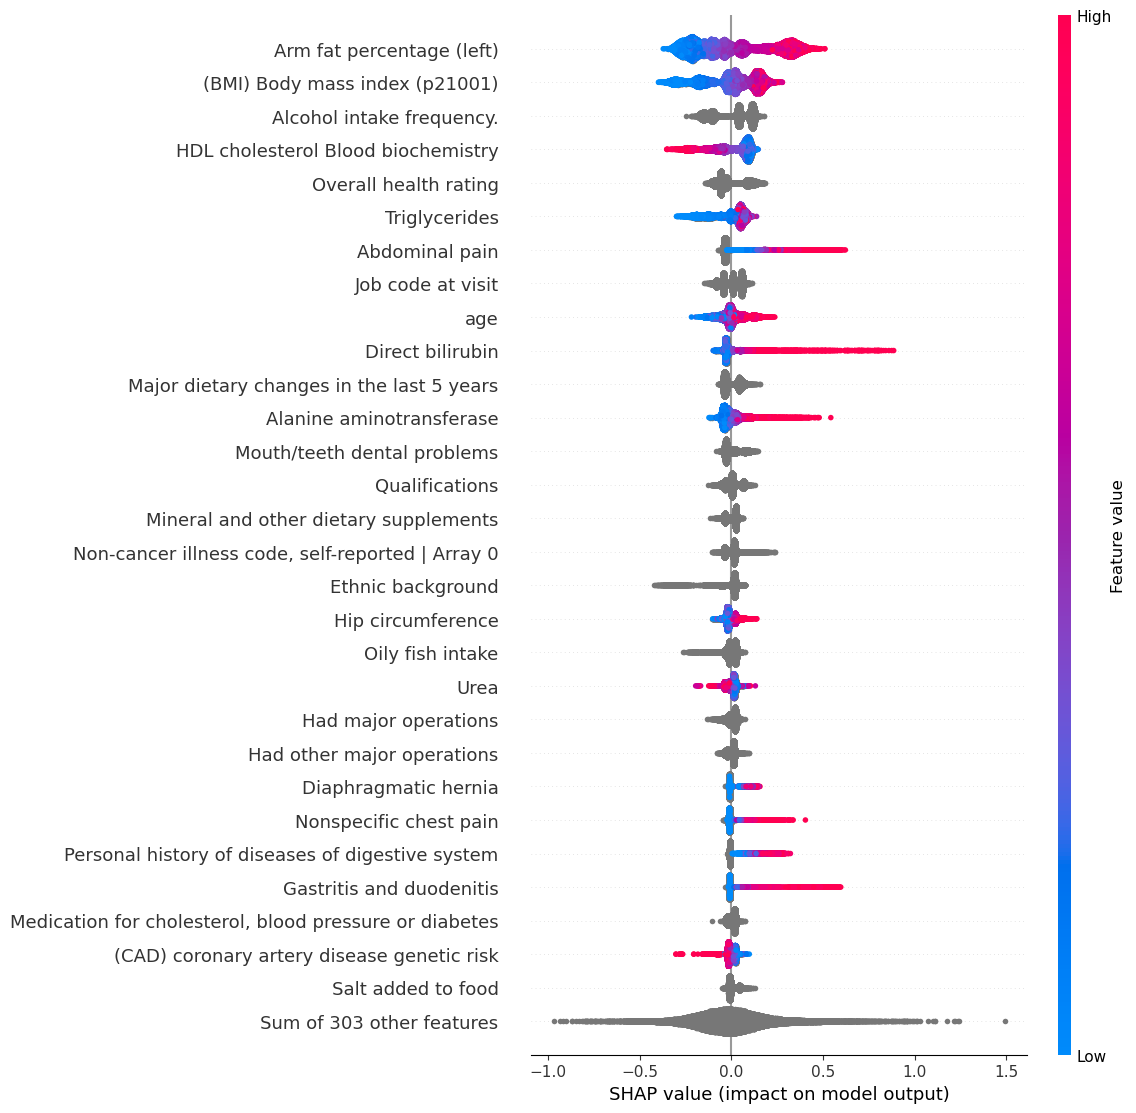

In [81]:
# X, categorical_cols,text_cols,numerical_cols = get_coltypes_list(X,return_X =True)
categorical_cols,text_cols,numerical_cols = get_coltypes_list(X,return_X =False)
shap_values = get_cb_shap(X,y,categorical_cols,text_cols)

Opt : pseudo RFE: Drop columns/feature groups with importance 0
* ALT: Boruta/ allrelevant FS / BorutaSHAP...


In [82]:
if do_stat_fs_filt:
    print(X.shape[1])
    # vals = np.abs(shap_values.values).mean(0)
    vals = shap_values
    feature_importance = pd.DataFrame(list(zip(X.columns.tolist(), #feature_names,
                                               vals)),
                                     columns=['name','feature_importance']).sort_values('feature_importance')
    
    # drop features unused by this model- optional. P value doesn't mean features used (e.g. if redundant)
    feature_importance = feature_importance.loc[(feature_importance["feature_importance"].abs()>0) | feature_importance["name"].isin(text_cols)].copy()
    
    X = X.filter(feature_importance.name,axis=1).copy() # keep only used features
    print(X.shape[1])
    categorical_cols,text_cols,numerical_cols = get_coltypes_list(X,return_X=False)

332
249
text_cols ['Non-cancer illness code, self-reported | Array 4', 'Mental health conditions ever diagnosed by a professional', 'Non-cancer illness code, self-reported | Array 2', 'Non-cancer illness code, self-reported | Array 5', 'Non-cancer illness code, self-reported | Array 6', 'Non-cancer illness code, self-reported | Array 3', 'Non-cancer illness code, self-reported | Array 1', 'Treatment/medication code | Array 0', '(non-UK origin) Country of Birth', 'Non-cancer illness code, self-reported | Array 0', 'Job code at visit']


### Pipeline explainer

In [83]:

# Preprocessing for categorical data
categorical_pipeline = Pipeline(steps=[
    # ('bool_to_str', BooleanToStringTransformer()),  # Convert booleans to strings
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',add_indicator=True)), # ,add_indicator=True
    ('onehot', OneHotEncoder(handle_unknown='ignore',min_frequency=25,
                             sparse_output=False, ## sparse outputs can cause issues wit hshap maybe? 
                             max_categories=90)),
     # ("FS_cat",SelectFdr(alpha=0.9)) # score_func=chi2,
     # ("FS_cat",SelectKBest(score_func=chi2, k=200)),
],
                                # memory="cat_pipeline_cache"
                               )

# Preprocessing for text data
## warning - multiple text columns needs different processing!
text_pipeline = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # causes error
    # ## CountVectorizer
    ('vectorizer', TfidfVectorizer(min_df=25,max_df= 0.85,ngram_range=(2, 2),max_features=230,
                                  # smooth_idf=False,sublinear_tf=True
                                   )),
    ("FS_text",SelectFdr(alpha=0.7)) # score_func=chi2,
],
                         # memory="text_pipeline_cache"
                        )

# Preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean',add_indicator=True)),
    ('scaler', StandardScaler()),
    # ('scaler', MaxAbsScaler()),
    # ("FS_num",SelectKBest(score_func=mutual_info_classif, k=600)),
    ("FS",SelectFromModel(ElasticNet(l1_ratio=0.2),threshold = "0.01*mean")),
])

## warning - multiple text columns needs different processing!
## https://github.com/scikit-learn/scikit-learn/issues/16148
 # *[(f'text_{f}', text_transformer, f) for f in text_features],

# Combine preprocessing steps
preprocessor = ColumnTransformer(#n_jobs=2, # ma ycrash? 
                                 # verbose_feature_names_out=False,
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols),
        # ('text', text_pipeline, text_cols) # ORIG
        *[(f'text_{f}', text_pipeline, f) for f in text_cols],
    ],
    remainder='passthrough',verbose=True
)

# Create a preprocessing and modeling pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           # ("FS",SelectKBest(score_func=mutual_info_classif, k=900)),
                           # ("FS",SelectFromModel(ElasticNet(l1_ratio=0.2),threshold = "5.05*mean")), ## may noit actually affect shap ? 
                           # ("CorrFS",SmartCorrelatedSelection(threshold= 0.98,#method=dcor.distance_correlation,
                           #                                    selection_method="variance")),
                           ('classifier',
                            clf_model
                        # HistGradientBoostingClassifier(min_samples_leaf=30,max_depth=8,random_state=42,categorical_features="from_dtype")
                                                               )],
                    # memory="pipeline_cache"
                   )
# pipeline.set_output(transform="pandas")       
# Split data
# X_train, X_test, y_train, y_test = train_test_split(X#.drop(columns=text_cols)
#                                                     ,y, test_size=0.1, random_state=42,stratify=y)

# Fit the pipeline
# pipeline.fit(X_train, y_train)
pipeline.fit(X, y)
print("Fitted")

[ColumnTransformer] .......... (1 of 13) Processing num, total=   0.2s
[ColumnTransformer] .......... (2 of 13) Processing cat, total=   1.6s
[ColumnTransformer]  (3 of 13) Processing text_Non-cancer illness code, self-reported | Array 4, total=   0.0s
[ColumnTransformer]  (4 of 13) Processing text_Mental health conditions ever diagnosed by a professional, total=   0.1s
[ColumnTransformer]  (5 of 13) Processing text_Non-cancer illness code, self-reported | Array 2, total=   0.1s
[ColumnTransformer]  (6 of 13) Processing text_Non-cancer illness code, self-reported | Array 5, total=   0.0s
[ColumnTransformer]  (7 of 13) Processing text_Non-cancer illness code, self-reported | Array 6, total=   0.0s
[ColumnTransformer]  (8 of 13) Processing text_Non-cancer illness code, self-reported | Array 3, total=   0.0s
[ColumnTransformer]  (9 of 13) Processing text_Non-cancer illness code, self-reported | Array 1, total=   0.1s
[ColumnTransformer]  (10 of 13) Processing text_Treatment/medication cod

In [84]:
## get # pipeline feature names
# print(len(pipeline[:-2].get_feature_names_out()))
print(len(pipeline[:-1].get_feature_names_out()))
# pipeline.named_steps['preprocessor'].transform(X.head()).shape[1]

2309


Get Shap vals:


 99%|===================| 5914/6000 [00:20<00:00]        

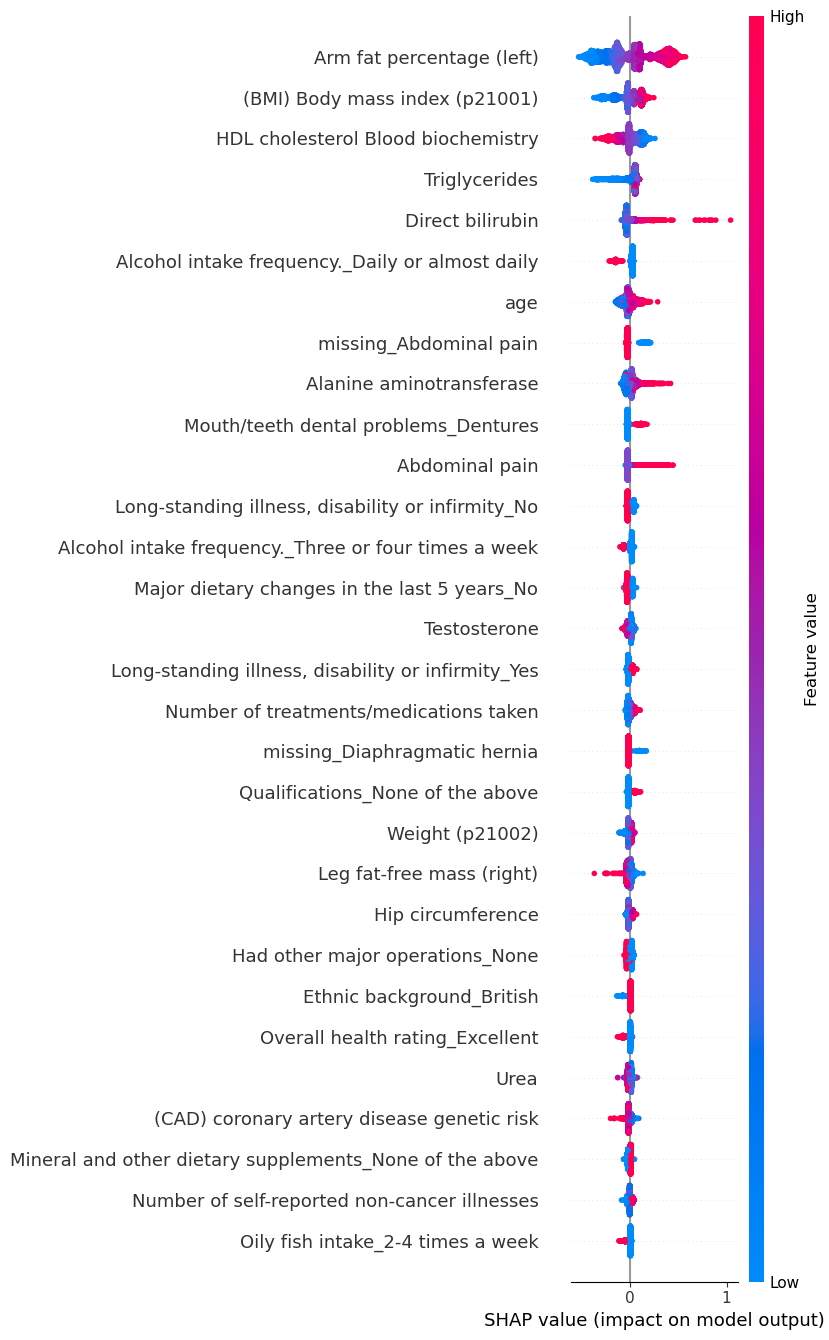

In [85]:

# # Generate SHAP values
# explainer = shap.Explainer(pipeline.named_steps['classifier'], pipeline.named_steps['preprocessor'].transform(X_train))
# shap_values = explainer(X_test)
# # Visualization
# shap.summary_plot(shap_values, feature_names=pipeline.named_steps['preprocessor'].get_feature_names())

## if using sklearn, set ,check_additivity=False

# # Generate SHAP values
### , cat_features=categorical_features_indices
# explainer = shap.Explainer(pipeline.named_steps['classifier'], pipeline.named_steps['preprocessor'].transform(X_train).values) # pandas output
# explainer = shap.Explainer(pipeline.named_steps['classifier'], pipeline.named_steps['preprocessor'].transform(X_train)) ## ORIG
# explainer = shap.TreeExplainer(pipeline.named_steps['classifier'],
#                            pipeline.named_steps['preprocessor'].transform(X.head(30_000).dropna(axis=1,thresh=100))) # .head(160_000) # try, alt

try:
    explainer = shap.TreeExplainer(pipeline.named_steps['classifier'],
                           pipeline.named_steps['preprocessor'].transform(X.sample(min(17_000,X.shape[0])))) # .head(160_000) # try, alt

except:
    print("Non interventional explainer") # needed if inuts are sparse/mixed sparse (due to ohe) maybe?
    explainer = shap.TreeExplainer(pipeline.named_steps['classifier']) # .head(160_000) # try, alt

print("Get Shap vals:")
# X2 = X

if FAST:
    # X2 = X.head(8_000)
    X2 = X.sample(n=min(6_000,X.shape[0]))
    # explainer = shap.TreeExplainer(pipeline.named_steps['classifier'], pipeline.named_steps['preprocessor'].transform(X_test))
    # shap_values = explainer(pipeline.named_steps['preprocessor'].transform(X),check_additivity=False)  #  X_test.values - with pandas output
else:
    # X2 = X
    # X2 = X.head(35_000)
    X2 = X.sample(n=min(120_000,X.shape[0]))


transformed_feature_names =  [x.replace("num__","").replace("cat__","").replace("text_","").replace("missingindicator","missing") for x in pipeline.named_steps['preprocessor'].get_feature_names_out()] # remove prefixes
shap_values = explainer(pipeline.named_steps['preprocessor'].transform(X2))
shap.summary_plot(shap_values, feature_names=transformed_feature_names,max_display=30)

## plt.savefig('fig_tes1.svg', bbox_inches='tight',dpi=100)

### features
* warning - cutoff_Date is strong feature (with high cutoff date -> lower chance of disease)

In [86]:
print(y.agg(["mean","sum","size"]).round(3))
if DO_CV:
    cv_eval(X,y)

mean        0.339
sum     17237.000
size    50909.000
Name: y, dtype: float64


* Oesophagus, no ipw:
roc_auc: 67.00 +-0.011 SD
accuracy: 99.65 +-0.000 SD
precision: 2.27 +-0.039 SD
recall: 0.08 +-0.001 SD
average_precision: 0.80 +-0.001 SD
f1: 0.15 +-0.003 SD

### Get top features
* Fails if using Categorical/string cols
* TODO: add columns of `p-value`, correlation (and direction) with target, +- lift, optimal boolean cutoff.

Q: Missing features: remove indicator maybe from name? 

* Note: `LIFT` here is relative to the _IPW subset_ (if that is being used).
* * TODO - we could reextract features over whole population (or subset of feats)... and get lift/feats on that

In [ ]:
X_trans = pipeline.named_steps['preprocessor'].transform(X)#,output="pandas")
print(X_trans.shape)
X_trans = pd.DataFrame(X_trans,columns=transformed_feature_names)
# X_trans.columns = X_trans.columns.str.replace("missing","",case=False).str.replace("__"," ",regex=False).str.strip() # was enabled , disable here
assert len(set(X_trans.columns)) == len(X_trans.columns),"non unique col names"

try:
    vals = np.abs(shap_values.values).mean(0)
except:
    vals = shap_values

# feature_names = X.columns
feature_names =transformed_feature_names

feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['name','feature_importance'])
## Add fdr P-value. 
## todo: is it uncorrected p-value? 
## hope order is the same?
fs = SelectFdr().fit(SimpleImputer().fit_transform(X_trans), y)

feature_importance["p_val"] = fs.pvalues_

# # drop features unused by this model- optional. P value doesn't mean features used (e.g. if redundant)
# feature_importance = feature_importance.loc[(feature_importance["feature_importance"]>0) | (feature_importance["p_val"]<0.0001)].copy()
# print(feature_importance.shape[0])
# feature_importance = feature_importance.loc[feature_importance["feature_importance"]>0].copy() # 0.00005
# print(feature_importance.shape[0], "# when Keeping features by shap only, not p value")

feature_importance = feature_importance.sort_values(by=['feature_importance'],
                              ascending=False).reset_index(drop=True).round(4)

# # drop weakest feats - optional - for easier viewing
# # feature_importance = feature_importance.loc[feature_importance["feature_importance"]>=0.0001] 
# feature_importance = feature_importance.loc[feature_importance["p_val"]<=0.7].copy()

## add correlation of each feature with target
corr_series = X_trans.select_dtypes("number").corrwith(y.astype(int),method="kendall").round(3) # spearman
corr_series.name = "corr"
feature_importance = feature_importance.merge(corr_series,left_on="name",right_index=True,how="left")

## support (non nans cases) per feature - meaningless with imputation
support_series = X_trans.count()
support_series.name = "support"
feature_importance = feature_importance.merge(support_series,left_on="name",right_index=True,how="left")

# ## positive class support (non nans cases) as % per feature
# pos_mask = (y>0)
# # support_series = 100*(X_trans.loc[pos_mask].count()/y.sum()).round(3) # ORIG
# support_series = 100*(X_trans[pos_mask].count()/y.sum()).round(3)
# support_series.name = "%Support_positiveClass"
# feature_importance = feature_importance.merge(support_series,left_on="name",right_index=True,how="left")

## Mutual info. Assumes things. not mrmr. Slow to calc? 
### could use MI from another library liek featureengine ?

feature_importance = feature_importance.loc[(feature_importance["p_val"] < 0.41) | (
            feature_importance["feature_importance"] > 0) | (feature_importance["corr"].abs() >= 0.01)].copy()

print(f"MI with target; on {feature_importance.shape[0]}")
try:
    # # ALT IV: Doesn't seem t o work that great by default
    # from feature_engine.selection import SelectByInformationValue
    # SelectByInformationValue(bins=5, strategy='equal_frequency', threshold=0.01)
    feature_importance["MutualInfoTarget"] = mutual_info_classif(X_trans.filter(feature_importance["name"],axis=1), y, n_jobs=-2) #  - needs newer sklearn version
except:
    feature_importance["MutualInfoTarget"] = mutual_info_classif(X_trans.filter(feature_importance["name"],axis=1), y)


# drop features unused by this model- optional. P value doesn't mean features used (e.g. if redundant). MI is univariate
print(feature_importance.shape[0])
feature_importance = feature_importance.loc[(feature_importance["feature_importance"]>0) | (feature_importance["MutualInfoTarget"]>=0.001) | (feature_importance["p_val"]<0.05)].copy()
print(feature_importance.shape[0])
feature_importance = feature_importance.loc[(feature_importance["MutualInfoTarget"]>=0.001) | (feature_importance["p_val"]<=0.08) | (feature_importance["feature_importance"]>=0.0004)].copy()
print(feature_importance.shape[0],"# after liberal union p-val filt")
# feature_importance = feature_importance.loc[feature_importance["feature_importance"]>0].copy() # 0.00005
print(feature_importance.shape[0], "# when Keeping features by shap only, not p value")

## added here - some cleaning of name. done here instead of earlier to allowfeat compat
## based on/replaces: X_trans.columns = X_trans.columns.str.replace("missing","",case=False).str.replace("__"," ",regex=False).str.strip()
feature_importance["raw_name"] = feature_importance["name"] 
feature_importance["name"] = feature_importance["name"].str.replace("missing","",case=False).str.replace("__"," ",regex=False).str.strip()
#################

# ## Optionally: do additional correlation FS. threshold is arbitrary here.. 
# ## note - takes time to run. 6 min e.g., after which 631/801 feats left

if do_stat_fs_filt:
    X_trans = X_trans.filter(feature_importance["raw_name"],axis=1).copy()
    print(X_trans.shape)
    ## Note! Need to manually readd text features / list_features_high_cardinality back in, they're excluded from X_encoded
    X_trans = SmartCorrelatedSelection(threshold= 0.89,selection_method = "model_performance",
                               # method=dcor.distance_correlation ## slower but more flexible, and leaves more cases
                               method=  "spearman", #"kendall",
                                estimator= RandomForestClassifier(n_estimators=40,min_samples_leaf=3,n_jobs=-2,max_depth=7), #DecisionTreeClassifier() #min_samples_leaf=3
                               ).fit_transform(X_trans,y) 
    print(X_trans.shape,"After extra corr FS")

    feature_importance = feature_importance.loc[feature_importance["raw_name"].isin(X_trans.columns) ].reset_index(drop=True)
    print(feature_importance.shape,"After extra decorr fs")
    assert feature_importance.shape[0]==X_trans.shape[1]


##################
## do cmim 
print("cmim")
cmim = CMIMFeatureSelector(task='classification')
cmim.fit_transform(X_trans.filter(feature_importance["raw_name"]),y)
pipeline_cmi_scores = cmim.cmi_scores_

feature_importance["cmim"] = pipeline_cmi_scores
feature_importance["cmim"] = feature_importance["cmim"].round(5)
##################
## get lift of optimal split per feature; for selected subset
print("Getting lift stats")
df_lift = get_optimal_splits_results(X_trans.filter(feature_importance["raw_name"],axis=1),y,
                                     max_depth=3, criterion='gini', min_support_pct=0.15,focus_on_lift=True,)
display(df_lift)
df_lift = df_lift.filter(['Feature', 'Lift (y==1)', 'Support',
                          #'Support (%)', 
                          'Target % Covered',
                 'Feature Split',],axis=1).set_index('Feature').add_prefix("F.Split-")
## add optimal split stats columns , with a prefix (F.Split-)
feature_importance = feature_importance.merge(df_lift,right_index=True,left_on="raw_name",how="inner",validate="1:1")

feature_importance = feature_importance.round(4)
if SAVE_OUTPUT:
    print(OUTPUT_FEATURE_REPORT_NAME,"Saved")
    feature_importance.to_csv(OUTPUT_FEATURE_REPORT_NAME,index=False)
    
feature_importance

(50909, 2309)
MI with target; on 1787
1787
1273
1255 # after liberal union p-val filt
1255 # when Keeping features by shap only, not p value
(50909, 1255)


In [ ]:
feature_importance.loc[feature_importance["MutualInfoTarget"]>=0.01].round(3).sort_values([ "feature_importance",
                                                                                           "MutualInfoTarget",
                                                                                       ],ascending=False)

In [ ]:
feature_importance.select_dtypes(["number"]).corr().round(2)

In [ ]:
feature_importance.loc[(feature_importance["feature_importance"]>0)].shape[0]

In [ ]:
feature_importance[feature_importance["p_val"]<0.01].name.tolist()

#### SHAP feature plots + Interactions
Interactions part not working - maybe due to dataset coverage vs tree or other stuff. Skip for now
* https://shap.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

* The interaction values display doesn't support categoricals (AS strings).
    *  we coud also change and use `display_features=xxx` , using 2 copies of the data, but nvm for now

In [ ]:
# # shap.dependence_plot("YOB", shap_values, X) ## gives error
# shap.dependence_plot("age", shap_values.values, X)

It takes a couple minutes since SHAP interaction values take a factor of 2 * # features
more time than SHAP values to compute. We'll only explain the first ~X,000 people in order to run quicker


In [ ]:
# 
# int_model = HistGradientBoostingClassifier(max_depth=4,
#     random_state=42, categorical_features="from_dtype",min_samples_leaf=45)

# if do_stat_fs_filt:
#     fs = SelectFdr(alpha=0.06)
#     fs.fit(X.fillna(0), y)
#     X_new = X.filter(fs.get_feature_names_out(),axis=1)
# else:
#     X_new = X.copy()
# X_new = X_new.drop(columns=["age_X_sex"],axis=1,errors="ignore").dropna(thresh=300,axis=1)
    
# print(X_new.shape)
# int_model.fit(X_new.drop(columns=["age_X_sex"],axis=1,errors="ignore"),y)
# print("refitted")

### check res if dropping novel featues
* NOTE! Feature names aren't identical due to cleaning?
* the inputs of this stage are run SEPERATELY from the normal run of this notebook - not ready in a single run here!



* We could do anotherversion of keeping only features with literature support.
    * that would need to run without the leaky FS to be meaningful

In [ ]:
# novel_candidates_filename = "candidate_novel_cuis_chol.csv" # = KG filtered, but not literature searched

## warning - may need to get raw_feature_name from these 2! 
# novel_candidates_filename = "chol_review_interesting_candidates_results.csv" # = KG and literature search filtered + Highest confidence
novel_candidates_filename = "chol_candidates_search_results.csv"

df_novel_candidates = pd.read_csv(novel_candidates_filename)
display(df_novel_candidates)
try:
    df_novel_candidates = df_novel_candidates.query("feature_level_sum_kg_hits<=1 & feature_level_avg_kg_hits<0.4")## stringent filter - ~ half as many features
except:
    df_novel_candidates = df_novel_candidates.loc[(df_novel_candidates["Co-occurrence Count"]==0) & (df_novel_candidates.feature_level_avg_kg_hits<0.3)]

if "Co-occurrence Count" in df_novel_candidates.columns.tolist():
    df_novel_candidates = df_novel_candidates.loc[df_novel_candidates["Co-occurrence Count"]==0]
df_novel_candidates.drop_duplicates(subset=["feature_name"],inplace=True)

novel_names = df_novel_candidates["feature_name"].unique()
print(len(novel_names))
df_novel_candidates


In [ ]:
# df_novel_candidates["feature_name"].uniques()
novel_names

In [ ]:
X.shape[1]

In [ ]:
X.filter(novel_names,axis=1).shape[1]

In [ ]:
# df_novel_candidates.query("feature_level_sum_kg_hits==0")["feature_name"].nunique()

In [ ]:
# df[df.columns.difference([i for i in df.columns if i.startswith('num'])]
X[X.columns.difference([i for i in X.columns if i in(novel_names)])].shape[1]

In [ ]:
print(X[X.columns.difference([i for i in X.columns if i not in(novel_names)])].shape[1])
X[X.columns.difference([i for i in X.columns if i not in(novel_names)])].columns

In [ ]:
X_no_novels = X[[i for i in X.columns if i not in(novel_names)]]
print(X_no_novels.shape)

In [ ]:
if DO_CV:
    cv_eval(X_no_novels,y)

# roc_auc: 62.88 +-0.002 SD
# accuracy: 94.26 +-0.000 SD
# precision: 12.94 +-0.014 SD
# recall: 1.39 +-0.002 SD
# average_precision: 8.36 +-0.001 SD
# f1: 2.51 +-0.003 SD

In [ ]:
# 
# if DO_CV:
#     cv_eval(X,y)

# roc_auc: 63.03 +-0.003 SD
# accuracy: 94.24 +-0.000 SD
# precision: 14.04 +-0.014 SD
# recall: 1.64 +-0.003 SD
# average_precision: 8.50 +-0.001 SD
# f1: 2.94 +-0.005 SD

In [ ]:
# pd.concat([X,y],axis=1).to_parquet("ms_data.parquet")

In [ ]:
# X2 = X.filter(novel_names,axis=1).dropna(thresh=50,axis=1).copy()
# display(X2.head(3))
# get_optimal_splits_results(X2,y)

jmi try

In [ ]:
X_trans

In [ ]:
cmim = CMIMFeatureSelector(task='classification')

# cmim.fit_transform(X_trans.filter(feature_importance["raw_name"]),y)
# pipeline_cmi_scores = cmim.cmi_scores_


# feature_importance["cmim"] = pipeline_cmi_scores
#     feature_importance["cmim"] = feature_importance["cmim"].round(5)

In [ ]:
X_trans.shape

In [ ]:
print(X_trans.filter(feature_importance.loc[(feature_importance["feature_importance"]>0)]["raw_name"]).shape)
print(X_trans.filter(feature_importance.loc[(feature_importance["feature_importance"]>0.01)]["raw_name"]).shape)

In [ ]:
# X2 = X_trans.filter(feature_importance.loc[(feature_importance["feature_importance"]>0)]["raw_name"]).copy()
X2 = X_trans.copy()
print(X2.shape)

In [ ]:
%%time
# cmim.fit_transform(X_trans,y)
# cmim.fit(X_trans.filter(feature_importance.loc[(feature_importance["feature_importance"]>0.01)]["raw_name"]),y)
cmim.fit(X2,y)

In [ ]:
# cmim.transform(X_trans.filter(feature_importance.loc[(feature_importance["feature_importance"]>0.01)]["raw_name"])).shape

In [ ]:
pipeline_cmi_scores = cmim.cmi_scores_

if X2.shape[0]==X.shape[0]:
    feature_importance["cmim"] = pipeline_cmi_scores
    feature_importance["cmim"] = feature_importance["cmim"].round(5)

In [ ]:
# ft_temp = feature_importance.loc[feature_importance["raw_name"].isin(X2.columns)]#.reset_index(drop=True)

# ft_temp["cmim"] = pipeline_cmi_scores
# display(ft_temp)

In [ ]:
# ft_temp.query("feature_importance>0.01 | cmim>0").sort_values(["cmim","feature_importance"],ascending=False).head(15)

feature_importance.query("feature_importance>0 | cmim>0.0001 | p_val<0.05").sort_values(["cmim","feature_importance"],ascending=False)#.head(15)

In [ ]:
feature_importance.tail()